# **DELE CA1 Part B**
###### --> By Tan Eu Zin, 2415927, From DAAA/FT/2B/22

#

# **Multi-class classification using RNN**
###### - In this project, we attempt to train an RNN model to carry out multi-class classification. 
###### - We train the model to predict the rating of the movie based on the reviews. 
###### - The data will be prepared by applying a class according to the score of the review, and then labelling it, and the model will try to predict on the label.

#

# **Imports** 
###### - Importing all necessary libraries and tools (mostly from keras)

In [111]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from googletrans import Translator
from sklearn.model_selection import train_test_split
from collections import Counter
import re
from nltk.corpus import wordnet
import random
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#

# **Setting random seed**
###### - Setting a random seed for this assignment to ensure consistent results.
###### - Doing so using tensorflow as most of the code is handling tensorflow.

In [112]:
# random seed set to 42
tf.random.set_seed(42)

#

# **Importing data**
###### - Importing data for used from the .csv file. 
###### - This dataset is given for Part B.
###### - Data is imported as "ds", stands for dataset.

In [113]:
# importing csv dataset
ds = pd.read_csv('Movie reviews.csv')

#

# **Raw Data cleaning and exploration**
###### - This is where data is explored, visualising it and deciding what to do with it to best suit our interests.
###### - We will also clean the data and make it usable to the best of our abilities.

In [114]:
# viewing the dataset's first few entries
ds.head()

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay


In [115]:
# view dataset info 
ds.info()

# we see that the dataset has 4 columns and 526 rows
# we also see that there are 0 non-null values in third column
# third column is empty and servers no purpose

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB


In [116]:
# looking at the third column...

# print the entire third column
third_column_name = ds.columns[2]
print("\nEntire third column :")
print(ds[third_column_name])

# since the third column is of no importance to us, we shall remove it 
# looking at the third column's name, we shall take it as a hint

# remove the third column
column_to_drop_by_index = ds.columns[2]
ds.drop(columns=[column_to_drop_by_index], inplace=True)

# confirmation for successful removal
print(f"\nColumn at ('{column_to_drop_by_index}') removed successfully.")
print("\nDataFrame head after removing the column:")
print(ds.head())


Entire third column :
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
522   NaN
523   NaN
524   NaN
525   NaN
526   NaN
Name: Are there ways for you to generate more data? Spliting up sentences, would that help?, Length: 527, dtype: float64

Column at ('Are there ways for you to generate more data? Spliting up sentences, would that help?') removed successfully.

DataFrame head after removing the column:
                                              Review  Score Language
0  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.1    Malay
1  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.9    Malay
2  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.5    Malay
3  Sayang sekali, pelakon tidak memberikan persem...    0.8    Malay
4  Jalan cerita yang kompleks dan penuh emosi. Su...    0.2    Malay


In [117]:
# we see that there's a language column, let's see what languages are in the dataset

# access the 'Language' column and then apply the .unique() method
unique_languages = ds['Language'].unique()

# print the result
print("Unique languages in the 'Language' column:")
print(unique_languages)

# the respective reviews are also in the respective language
# we need to translate them to all english 
# this will make all the data easier to augment

Unique languages in the 'Language' column:
['Malay' 'English' 'Chinese' 'Nippon']


In [118]:
# using google translate to translate the reviews

# initialize the translator
translator = Translator()

# function to translate text 
def translate_text_to_english_simple(text):
    if pd.isna(text) or str(text).strip() == "":
        return text
    try:
        return translator.translate(str(text), dest='en').text
    except:
        return text # return original on error

# apply the translation to review column
print("Translating 'Review' column to English...")
ds['Review'] = ds['Review'].apply(translate_text_to_english_simple)
print("Translation complete.")

# display the first few rows of the translated column to verify successful translation
print("\nDataFrame head with translated 'Review_English' column:")
print(ds[['Review']].head())

Translating 'Review' column to English...
Translation complete.

DataFrame head with translated 'Review_English' column:
                                              Review
0  This movie is great! Thrilling action and shoc...
1  This movie is great! Thrilling action and shoc...
2  This movie is great! Thrilling action and shoc...
3  Unfortunately, the actor didn't give the best ...
4  Complex and emotional storyline. So entertaining!


In [119]:
# now that the movie reviews are all translated to english, we can remove the language column since it's all going to be "English" and there's no point leaving it there

# remove the 'Language' column
ds.drop(columns=['Language'], inplace=True)

print("The 'Language' column has been removed.")
print("\nDataFrame head after removing the 'Language' column:")
print(ds.head())

# now the language column has been removed 

The 'Language' column has been removed.

DataFrame head after removing the 'Language' column:
                                              Review  Score
0  This movie is great! Thrilling action and shoc...    0.1
1  This movie is great! Thrilling action and shoc...    0.9
2  This movie is great! Thrilling action and shoc...    0.5
3  Unfortunately, the actor didn't give the best ...    0.8
4  Complex and emotional storyline. So entertaining!    0.2


In [120]:
# looking at the reviews and the scores manually, there's something off
# the better the reviews, the lower the score
# and the worse the reviews, the worse the score

# apply the formula (1 - original_rating) to the 'Score' column
# and round the result to 2 decimal places

ds['Score'] = (1 - ds['Score']).round(2)

print("The 'Score' column has been updated with the new rating system (1 - original_rating) and rounded to 2 decimal places.")
print("\nDataFrame head with the updated 'Score' column:")
print(ds.head(10))

The 'Score' column has been updated with the new rating system (1 - original_rating) and rounded to 2 decimal places.

DataFrame head with the updated 'Score' column:
                                              Review  Score
0  This movie is great! Thrilling action and shoc...   0.90
1  This movie is great! Thrilling action and shoc...   0.10
2  This movie is great! Thrilling action and shoc...   0.50
3  Unfortunately, the actor didn't give the best ...   0.20
4  Complex and emotional storyline. So entertaining!   0.80
5  The filmmaker succeeded in providing an unforg...   0.95
6  Action scenes that are too much and surprising...   0.60
7  I'm excited throughout the movie. Interesting ...   0.85
8  Avengers: Endgame is disappointing and boring....   0.15
9  The integration of science fiction elements is...   0.75


In [121]:
# now we check for anomalies in the dataset 
# anomalies include duplicated data and rows with missing values 


# here we check and drop duplicates
print("--- Checking and Dropping Duplicates ---")

# check for duplicates
num_duplicates_before = ds.duplicated().sum()
print(f"Number of duplicate rows found BEFORE dropping: {num_duplicates_before}")

# if there's duplicates, drop them, else no need to do anything
if num_duplicates_before > 0:
    print("\nDisplaying duplicate rows:")

    # display all duplicate rows including their first occurrences
    sorted_duplicates = ds[ds.duplicated(keep=False)].sort_values(by=list(ds.columns))
    print(sorted_duplicates)
    
    # drop duplicate rows
    initial_rows_before_drop = ds.shape[0]
    ds.drop_duplicates(inplace=True)
    num_rows_after_duplicate_drop = ds.shape[0]
    
    # show the number of duplicated rows dropped
    print(f"\nDropped {initial_rows_before_drop - num_rows_after_duplicate_drop} duplicate rows.")
    print(f"DataFrame shape AFTER dropping duplicates: {ds.shape}")
else:
    
    # if no duplicates, no need to do anything 
    print("\nNo duplicate rows found.")


# here we check for null rows
print("\n--- Checking and Dropping Rows with NA Values ---")

# check for null values
print("\nNumber of NA values per column BEFORE dropping:")
print(ds.isnull().sum())

# dropping rows with any NA values
initial_rows_before_na_drop = ds.shape[0]
ds.dropna(inplace=True)
num_rows_after_na_drop = ds.shape[0]

# viewing the dataset size after dropping
print(f"\nDropped {initial_rows_before_na_drop - num_rows_after_na_drop} rows with NA values.")
print(f"DataFrame shape AFTER dropping NA values: {ds.shape}")

# a model exposed to the same data points multiple times during training might overemphasize those specific patterns,  this can lead to overfitting so we remove the duplicates 
# we also remove rows with missing values because these values cannot be replaced with something else, it makes the data unfair and weird

--- Checking and Dropping Duplicates ---
Number of duplicate rows found BEFORE dropping: 115

Displaying duplicate rows:
                                                Review  Score
53   A big surprise in the middle of the movie! Thr...   0.88
83   A big surprise in the middle of the movie! Thr...   0.88
152  A big surprise in the middle of the movie! Thr...   0.88
59    A complex and mysterious plot. Very interesting!   0.85
89    A complex and mysterious plot. Very interesting!   0.85
..                                                 ...    ...
387  While Avengers: Endgame provides closure to so...   0.60
377  While the film delivers on emotional beats, ce...   0.75
394  While the film delivers on emotional beats, ce...   0.75
361  While the film provides closure to some charac...   0.70
384  While the film provides closure to some charac...   0.70

[197 rows x 2 columns]

Dropped 115 duplicate rows.
DataFrame shape AFTER dropping duplicates: (412, 2)

--- Checking and Dropping Row

In [122]:
# now we add labels to the class for classification 

# very good - 0.8 to 1.0 score 
# good - 0.6 to 0.8
# average - 0.4 to 0.6
# bad - 0.2 to 0.4 
# very bad - 0.0 to 0.2 

# now, create the 'Rating' column based on the 'Score'
print("\n--- Creating 'Rating' column based on 'Score' ---")

# defining the bins and labels for categorization 
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Bad', 'Bad', 'Average', 'Good', 'Very Good']

# use pd.cut to categorize the 'Score' column
# "include_lowest=True" ensures that the lowest value (0.0) is included in the first bin
ds['Rating'] = pd.cut(ds['Score'], bins=bins, labels=labels, right=True, include_lowest=True)

# verify that the new rating column is added successfully 
print("New 'Rating' column created.")
print("\nDataFrame head with the new 'Rating' column:")
print(ds.head())

# showing the value counts for the new 'Rating' column 
print("\nValue counts for the new 'Rating' column:")
print(ds['Rating'].value_counts())


--- Creating 'Rating' column based on 'Score' ---
New 'Rating' column created.

DataFrame head with the new 'Rating' column:
                                              Review  Score     Rating
0  This movie is great! Thrilling action and shoc...    0.9  Very Good
1  This movie is great! Thrilling action and shoc...    0.1   Very Bad
2  This movie is great! Thrilling action and shoc...    0.5    Average
3  Unfortunately, the actor didn't give the best ...    0.2   Very Bad
4  Complex and emotional storyline. So entertaining!    0.8       Good

Value counts for the new 'Rating' column:
Rating
Very Good    255
Bad           78
Good          30
Average       27
Very Bad      20
Name: count, dtype: int64


In [123]:
# drop the 'Score' column as it's no longer needed since the 'Rating' column provides the necessary information 
ds.drop(columns=['Score'], inplace=True)

# print resuts 
print("The 'Score' column has been removed.")
print("\nDataFrame head after removing the 'Score' column :")
print(ds.head())

The 'Score' column has been removed.

DataFrame head after removing the 'Score' column :
                                              Review     Rating
0  This movie is great! Thrilling action and shoc...  Very Good
1  This movie is great! Thrilling action and shoc...   Very Bad
2  This movie is great! Thrilling action and shoc...    Average
3  Unfortunately, the actor didn't give the best ...   Very Bad
4  Complex and emotional storyline. So entertaining!       Good


#

# **Splitting data into train and test data**
###### - Now that the data is clean, we can splti the data.
###### - We need to split the data into 70% train data and 30% test data. 
###### - The train data will be augmented to make more data, and also make the number of data in each class to be equal, while the test data will be left untouched.

In [124]:
# splitting the data into 70% train and 30% test

# stratify ensures the class distribution is preserved in both splits
train_ds, test_ds = train_test_split(ds, test_size=0.3, random_state=42, stratify=ds['Rating'])

# check the shaope of the train and test datasets 
print(f"Train set shape: {train_ds.shape}")
print(f"Test set shape: {test_ds.shape}")

# now we view the first 10 entries of both train and test datasets to confirm the split
print("\nTrain set :\n")
print(train_ds.head(10))
print("\nTest set :\n")
print(test_ds.head(10))

# now we proceed to visualize the train data to check for class imbalance

Train set shape: (287, 2)
Test set shape: (123, 2)

Train set :

                                                Review     Rating
354  The intricate plot weaves together multiple ti...  Very Good
301  I'm impressed with how the film incorporates e...  Very Good
232  Unfortunately, the plot of this film is too op...        Bad
255  Lack of tension in the plot makes me bored. No...        Bad
455                                     Intricate plot  Very Good
374  While Avengers: Endgame is a visual spectacle,...       Good
367  While the film attempts to tie up loose ends, ...       Good
280  The film creates an immersive atmosphere that ...  Very Good
221  Dramatic and impactful action scenes. Too many...        Bad
337  The performances of the cast in Avengers: Endg...  Very Good

Test set :

                                                Review     Rating
217  Amazing action and a plot full of surprises. I...  Very Good
43   The storyline is quite common but is turned on...       Goo

#

# **Visualising the train data** 
###### - Now we visualise the data in train_ds. 
###### - We will see if there's anything that should be done (or if it is unbalanced.)

C:\Users\ezinn\AppData\Local\Temp\ipykernel_150900\3414664356.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='viridis')


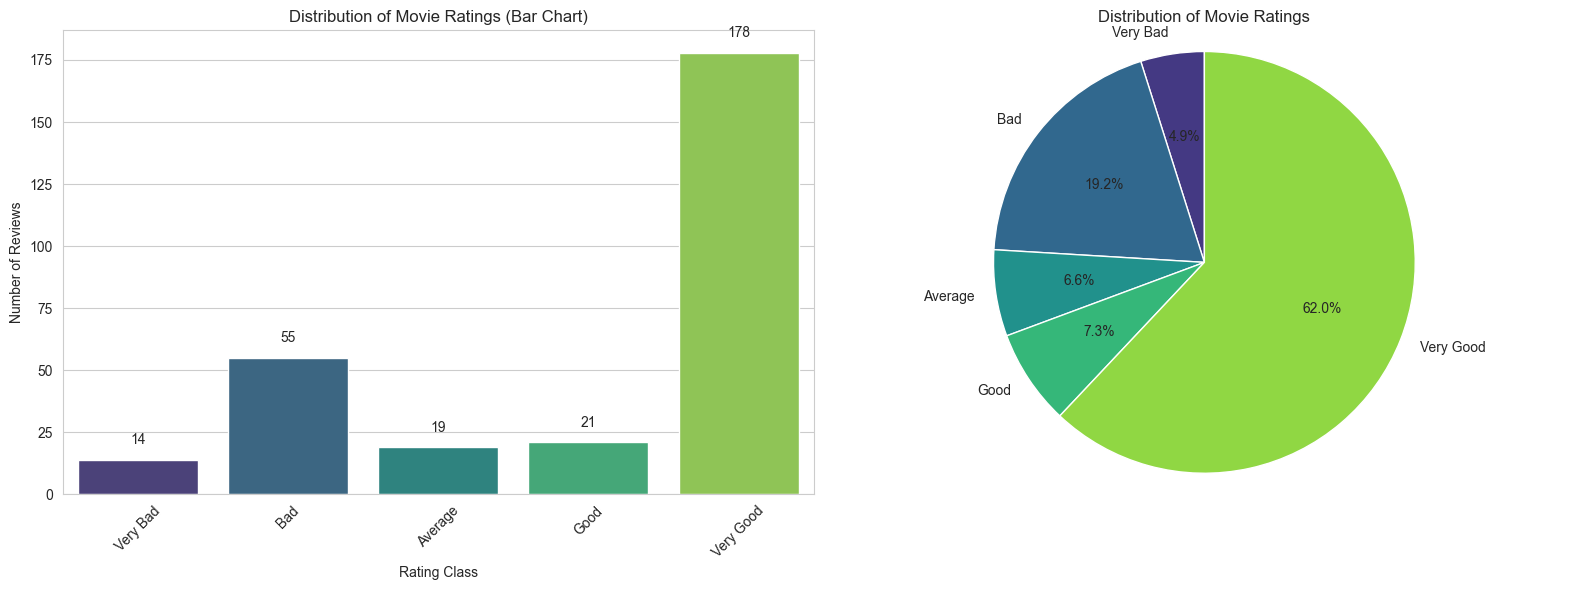

In [125]:
# now we visualize the distribution of the ratings using a bar chart and a pie chart

# set a style for the plots
sns.set_style("whitegrid")

# creating a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

####################################################################################################################################

# plotting the bar chart 
rating_counts = train_ds['Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Movie Ratings (Bar Chart)')
axes[0].set_xlabel('Rating Class')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45) # rotate x-axis labels for better readability

# add text labels on top of the bars
for index, value in enumerate(rating_counts.values):
    axes[0].text(index, value + 5, str(value), ha='center', va='bottom')

####################################################################################################################################

# plotting the pie chart to visualize the distribution of movie ratings 

# calculate percentages for the pie chart
percentages = train_ds['Rating'].value_counts(normalize=True).sort_index() * 100

# plotting the pie chart
axes[1].pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(percentages)))
axes[1].set_title('Distribution of Movie Ratings')
axes[1].axis('equal') # equal aspect ratio ensures that pie is drawn as a circle 

####################################################################################################################################

# show the plots
plt.tight_layout() 
plt.show()

#

# **Augmenting train data**
###### - The train data is not balanced, with some classes having more and some classes having less data. 
###### - This biasness in the train data can also make the model biased when predicting certain classes. 
###### - Hence we make the classes all have the same number of data. 
###### - Furthermore, we make MORE data such that the model has more data to work with.

#

### **Data Augmentation via Full Stop Separation**

In some cases, a review may contain multiple sentences. To augment the data, we can split rows that contain two (or more) sentences into separate rows. For each review:
###### - Keep the original review (with two sentences).
###### - Create a new row with only the first sentence.
###### - Create another row with only the second sentence.
###### --> This augmentation increases the number of training examples and might help the model learn sentence-level nuances.

In [126]:
# function to augment the dataset by splitting reviews at full stops

def augment_by_fullstop_split(df, review_col='Review'):

    augmented_rows = []

    # iterate through each row in the DataFrame
    for idx, row in df.iterrows():

        text = row[review_col]

        # split the review text by full stops and strip whitespace
        # this assumes that sentences are separated by a period followed by a space
        sentences = [s.strip() for s in text.split('.') if s.strip()]

        # first, add the original row
        augmented_rows.append(row)

        # if the review has more than one sentence, create a new row for each sentence
        if len(sentences) >= 2:
            for sentence in sentences:
                new_row = row.copy()
                new_row[review_col] = sentence
                augmented_rows.append(new_row)

    # return a new DataFrame with the augmented data
    return pd.DataFrame(augmented_rows)

# augment the train_ds dataset
train_ds = augment_by_fullstop_split(train_ds)

# verify the augmentation
print("Training set shape after augmenting :", train_ds.shape)

Training set shape after augmenting : (705, 2)


#

### **Data Augmentation via Synonym Replacement**

Synonym replacement is a technique used to create new data samples by replacing certain words in a sentence with their synonyms. This helps generate variations of the same sentence while preserving its overall meaning.

###### - The text is tokenized into individual words.
###### - For each word (typically longer than three characters), the script looks up synonyms using WordNet.
###### - One or more words are randomly replaced with one of their synonyms.
###### - The resulting sentence is different from the original while maintaining the same overall sentiment or information.

In [127]:
# now we carry out synonym replacement to further augment the dataset

# defining synonym replacement function using NLTK's WordNet
def synonym_replacement(text, num_replacements=1):

    words = text.split()
    new_words = words.copy()

    # consider words longer than 3 letters
    candidates = [word for word in words if len(word) > 3]

    random.shuffle(candidates)

    replaced = 0

    for word in candidates:

        synonyms = wordnet.synsets(word)

        # get synonyms excluding the original word
        synonym_words = {lemma.name() for syn in synonyms for lemma in syn.lemmas() if lemma.name().lower() != word.lower()}

        if len(synonym_words) > 0:
            synonym = random.choice(list(synonym_words))
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
        if replaced >= num_replacements:
            break
    return ' '.join(new_words)

In [128]:
# defining empty augmented rows list 
augmented_rows = []

# iterate over each row in the dataset
for idx, row in train_ds.iterrows():

    # add the original row first
    augmented_rows.append(row)
    
    # generate augmented text using synonym replacement
    augmented_text = synonym_replacement(row['Review'], num_replacements=2)
    
    # if the augmented review is different, add as a new row
    if augmented_text != row['Review']:
        new_row = row.copy()
        new_row['Review'] = augmented_text
        augmented_rows.append(new_row)

# create a new dataframe including the augmented rows
train_ds = pd.DataFrame(augmented_rows)

# show a few examples of the augmentation
print("Original vs Augmented (as separate rows):")
print(train_ds[['Review']].head(10))
print("\nTotal number of rows after synonym replacement augmentation:", train_ds.shape[0])  

Original vs Augmented (as separate rows):
                                                Review
354  The intricate plot weaves together multiple ti...
354  The intricate plot weaves in_concert multiple ...
354  The intricate plot weaves together multiple ti...
354  The intricate plot weaves together multiple ti...
354  The stellar performances from the cast and the...
354  The astral performances from the cast and the ...
301  I'm impressed with how the film incorporates e...
301  I'm impressed with how the film integrate elem...
232  Unfortunately, the plot of this film is too op...
232  Unfortunately, the plot_of_land of this cellul...

Total number of rows after synonym replacement augmentation: 1370


#

### **Data Augmentation via Back Translation**

Back translation is a data augmentation approach where the original text is translated into an intermediate language and then translated back to the source language. This process creates a paraphrased version of the text while preserving its overall meaning. Using back translation can help increase the diversity of your training data, making your model more robust to variations in wording.
###### - The original text (in English) is translated into an intermediate language (e.g., French).
###### - The translated text is then translated back from the intermediate language to English.
###### - The resulting text often varies in structure and word choice, providing natural language variations.

In [129]:
# create an instance of the translator
translator = Translator()

def back_translate(text, src='en', mid='fr'):

    try:
        # translate the original text to the intermediate language
        translated = translator.translate(text, src=src, dest=mid)

        # translate the resulting text back to the source language
        back_translated = translator.translate(translated.text, src=mid, dest=src)

        # return the back translated text
        return back_translated.text
    
    except Exception as e:

        # if an error occurs, print the error message and return the original text
        print("Error in back translation:", e)
        return text

In [130]:
# iterate over each row in train_ds and create an augmented version via back translation

# defining empty augmented rows list 
augmented_rows = []

for idx, row in train_ds.iterrows():
    # add the original row first
    augmented_rows.append(row)
    
    # generate augmented text using back translation
    augmented_text = back_translate(row['Review'], src='en', mid='fr')
    
    # if the back translated text is different from the original, add it as a new row
    if augmented_text != row['Review']:
        new_row = row.copy()
        new_row['Review'] = augmented_text
        augmented_rows.append(new_row)

# create a new dataframe with the augmented rows
train_ds = pd.DataFrame(augmented_rows)

# print a few examples and display the new size of train_ds
print("original vs back translated (as separate rows):")
print(train_ds[['Review']].head(10))
print("\ntotal number of rows after back translation augmentation:", train_ds.shape[0])

original vs back translated (as separate rows):
                                                Review
354  The intricate plot weaves together multiple ti...
354  The complex intrigue weaves several calendars,...
354  The intricate plot weaves in_concert multiple ...
354  The complex intrigue weaves in multiple chrono...
354  The intricate plot weaves together multiple ti...
354  The complex intrigue weaves several deadlines,...
354  The intricate plot weaves together multiple ti...
354  The complex intrigue takes several deadlines t...
354  The stellar performances from the cast and the...
354  The stellar performance of the distribution an...

total number of rows after back translation augmentation: 2565


#

### **Augmenting data by class** (Upsampling)
###### - Now that we have augmented the data using full stop separation, back translation and synonym replacement, we have to make sure the data is balanced.
###### - We plot a visualisation to check, if it is not balanced, we will use scikit lean's resample to augment it to make all classes balanced. 

C:\Users\ezinn\AppData\Local\Temp\ipykernel_150900\4092093028.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='viridis')


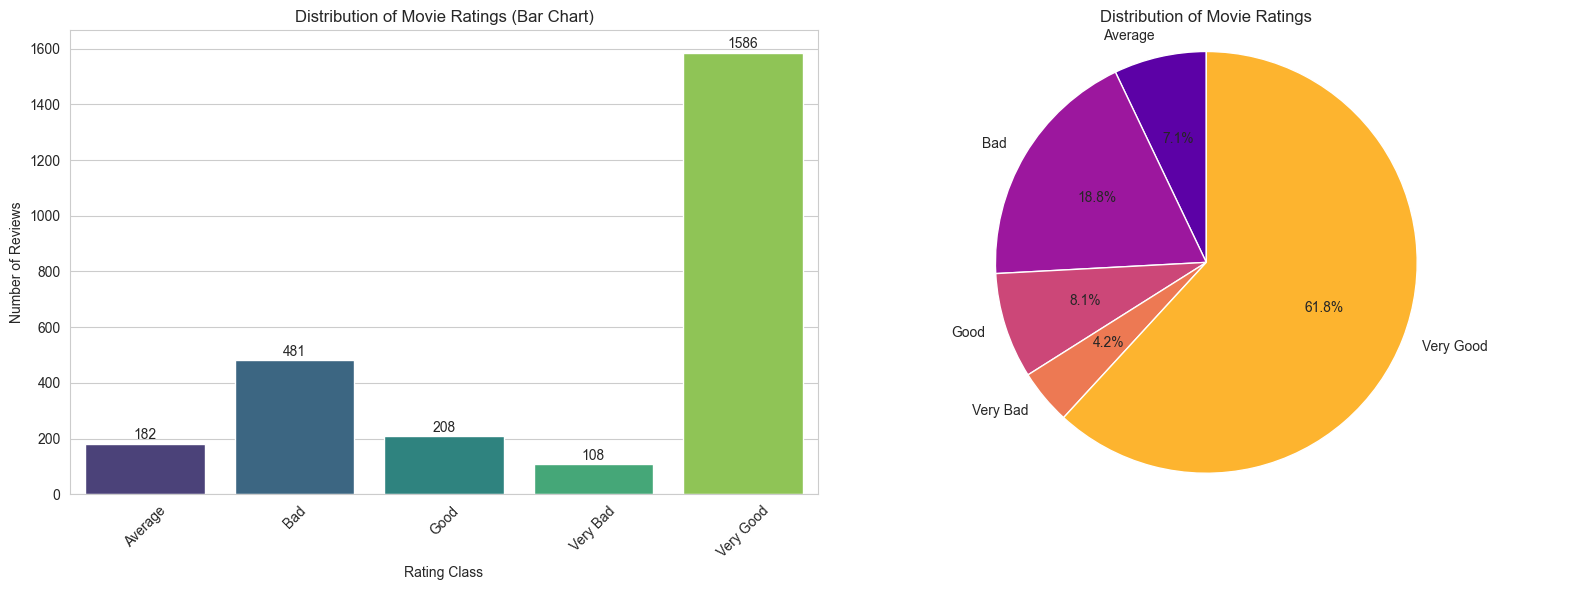

In [131]:
# now we visualize the distribution of the ratings using a bar chart and a pie chart

# set a style for the plots
sns.set_style("whitegrid")

# creating a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

####################################################################################################################################

# plotting the bar chart 
rating_counts = train_ds['Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Movie Ratings (Bar Chart)')
axes[0].set_xlabel('Rating Class')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45) # rotate x-axis labels for better readability

# add text labels on top of the bars
for index, value in enumerate(rating_counts.values):
    axes[0].text(index, value + 5, str(value), ha='center', va='bottom')

####################################################################################################################################

# plotting the pie chart to visualize the distribution of movie ratings 

# calculate percentages for the pie chart
percentages = train_ds['Rating'].value_counts(normalize=True).sort_index() * 100

# plotting the pie chart
axes[1].pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('plasma', len(percentages)))
axes[1].set_title('Distribution of Movie Ratings')
axes[1].axis('equal') # equal aspect ratio ensures that pie is drawn as a circle 

####################################################################################################################################

# show the plots
plt.tight_layout() 
plt.show()

In [132]:
# looking at how the data is distributed, we see that the data is imbalanced 
# so we will use the resampling technique to balance the dataset

# find the class with the most samples (majority class)
max_class_size = train_ds['Rating'].value_counts().max()

# upsample each class to match the majority class size (or more, if you want to further increase data)
augmented_train_list = []

for label in train_ds['Rating'].unique():

    class_subset = train_ds[train_ds['Rating'] == label]

    # upsample with replacement
    class_upsampled = resample(
        class_subset,
        replace=True,                # sample with replacement
        n_samples=max_class_size,    
        random_state=42
    )

    augmented_train_list.append(class_upsampled)

# concatenate all upsampled classes
train_ds = pd.concat(augmented_train_list).sample(frac=1, random_state=42).reset_index(drop=True)

# verify the class distribution after resampling
print("\nAugmented train set class distribution:")
print(train_ds['Rating'].value_counts())
print(f"\nAugmented train set shape: {train_ds.shape}")

# now, we can use our augmented train_ds for model training after cleaning the augmented data


Augmented train set class distribution:
Rating
Very Good    1586
Very Bad     1586
Average      1586
Bad          1586
Good         1586
Name: count, dtype: int64

Augmented train set shape: (7930, 2)


#

# **Augmented data cleaning**
###### - Now that we augmented data, we have to clean it again. 
###### - We do so by dropping duplicated rows of data as there might be duplicates produced. 
###### - After doing so, we can prepare our data and use it.

In [133]:
# drop duplicate rows in train_ds
train_ds.drop_duplicates(inplace=True)
print("New shape after dropping duplicates :", train_ds.shape)

New shape after dropping duplicates : (1891, 2)


C:\Users\ezinn\AppData\Local\Temp\ipykernel_150900\920598955.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='viridis')


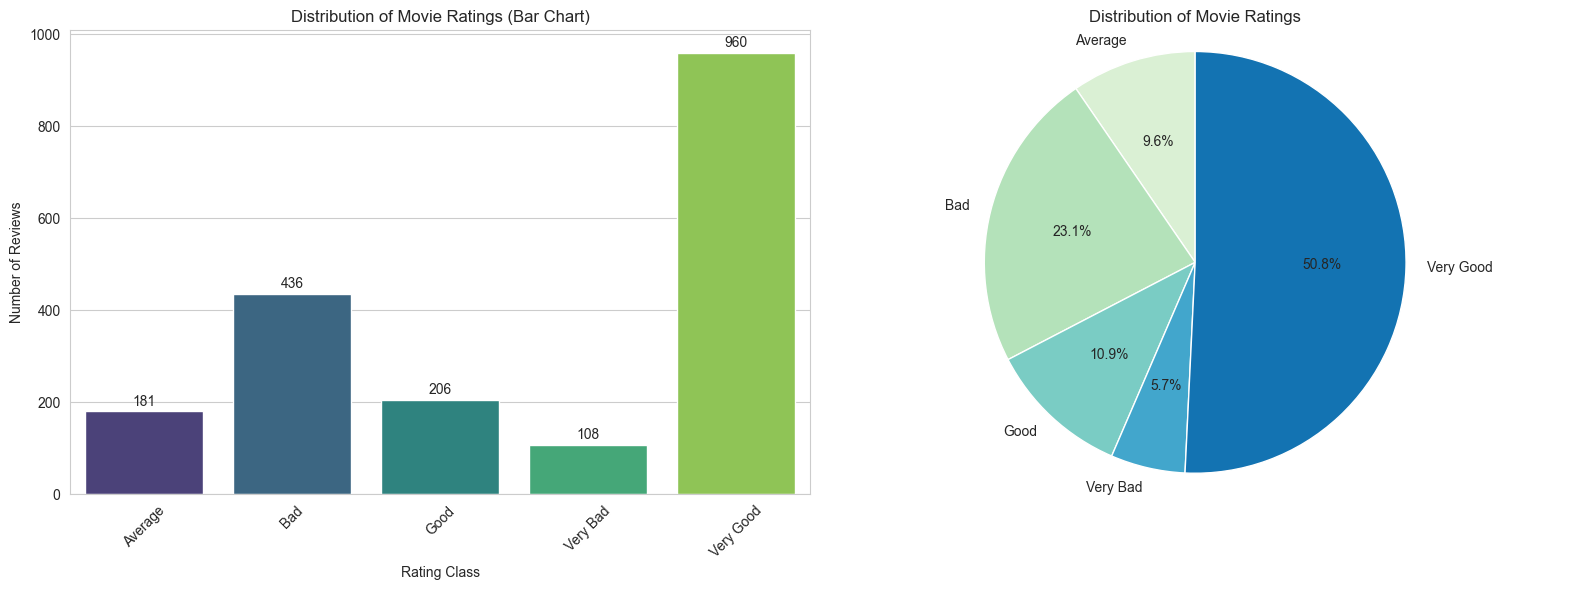

In [134]:
# AFTER REMOVING DUPLICATES, WE VIEW THE DATA AGAIN

# we visualize the distribution of the ratings using a bar chart and a pie chart 

# set a style for the plots
sns.set_style("whitegrid")

# creating a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

####################################################################################################################################

# plotting the bar chart 
rating_counts = train_ds['Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Movie Ratings (Bar Chart)')
axes[0].set_xlabel('Rating Class')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45) # rotate x-axis labels for better readability

# add text labels on top of the bars
for index, value in enumerate(rating_counts.values):
    axes[0].text(index, value + 5, str(value), ha='center', va='bottom')

####################################################################################################################################

# plotting the pie chart to visualize the distribution of movie ratings 

# calculate percentages for the pie chart
percentages = train_ds['Rating'].value_counts(normalize=True).sort_index() * 100

# plotting the pie chart
axes[1].pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('GnBu', len(percentages)))
axes[1].set_title('Distribution of Movie Ratings')
axes[1].axis('equal') # equal aspect ratio ensures that pie is drawn as a circle 

####################################################################################################################################

# show the plots
plt.tight_layout() 
plt.show()

### Data is still biased
###### - This is because while augmenting, many duplicates were created, especially for upsampling.
###### - We will still try to see if this data is usable as the biasness and imbalanced has decreased.
###### - If it is not, we will try other solutions (eg other ways of augmenting, or class weights).

#

# **Data preparation**
###### - Here, we analyze the data and go deeper, seeing what we can do to the to make it usable for our model. 

#

### **Data lemmetization** 
###### - Lemmatization reduces words to their base or dictionary form (e.g., "running" → "run").
###### - It helps standardize words, reducing vocabulary size and improving model performance.
###### - This is needed so that different forms of a word are treated as the same feature during analysis.

In [135]:
# first we lemmatize the reviews to reduce vocabulary size and improve model performance

# define lemmatizer 
lemmatizer = WordNetLemmatizer()

# function to lemmatize text
def lemmatize_text(text):
    words = str(text).split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# apply lemmatization to the 'Review' column in both train and test sets
train_ds['Review'] = train_ds['Review'].apply(lemmatize_text)
test_ds['Review'] = test_ds['Review'].apply(lemmatize_text)

# check the effect of lemmatization (if it is visually noticeable)

print("First 10 reviews in train_ds after lemmatization:\n")
print(train_ds['Review'].head(10))

print("\nFirst 10 reviews in test_ds after lemmatization:\n")
print(test_ds['Review'].head(10))

First 10 reviews in train_ds after lemmatization:

0                              Engaging the narration!
1    This pic is very disappointing. Not deserving ...
2    Avengers: Endgame's CGI and practical impressi...
3                                   Exaggerated moment
4     The film ha great emotional strength. Pulsation!
5                                       Too not washed
6    Avengers: The end of the game is disappointing...
7    This movie is great! Thrilling action and shoc...
8               on_that_point is no acceptable closure
9    Avengers: Endgame, however, excels in create e...
Name: Review, dtype: object

First 10 reviews in test_ds after lemmatization:

217    Amazing action and a plot full of surprises. I...
43     The storyline is quite common but is turned on...
436                                         Over-the-top
105    The movie is really impressive with deep feeli...
477                                   Entertaining blend
338    While the overarching plot o

#

### **Reducing stopwords**
###### - Removing stopwords eliminates common words (like "the", "is", "and") that do not carry significant meaning for analysis.
###### - This reduces noise in the data and helps the model focus on important words.
###### - It improves model performance by reducing irrelevant features.

In [136]:
# next we will reduce stopwords to reduce noise in the data and improve model performance 

# define the set of stopwords
stop_words = set(stopwords.words('english'))

# define remove_stopwords function
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

# applying the remove_stopwords function to the 'Review' column in both train and test datasets 
train_ds['Review'] = train_ds['Review'].apply(remove_stopwords)
test_ds['Review'] = test_ds['Review'].apply(remove_stopwords)

# check the effect of removing stopwords (if it is visually noticeable)

print("First 10 reviews in train_ds after stopword removal:\n")
print(train_ds['Review'].head(10))

print("\nFirst 10 reviews in test_ds after stopword removal:\n")
print(test_ds['Review'].head(10))

First 10 reviews in train_ds after stopword removal:

0                                  Engaging narration!
1          This pic disappointing. Not deserving hype.
2    Avengers: Endgame's CGI practical impression s...
3                                   Exaggerated moment
4     The film ha great emotional strength. Pulsation!
5                                           Too washed
6          Avengers: The end game disappointing boring
7    This movie great! Thrilling action shocking plot.
8                     on_that_point acceptable closure
9    Avengers: Endgame, however, excels create epic...
Name: Review, dtype: object

First 10 reviews in test_ds after stopword removal:

217    Amazing action plot full surprises. I'm impres...
43       The storyline quite common turned great action.
436                                         Over-the-top
105           The movie really impressive deep feelings.
477                                   Entertaining blend
338    While overarching plot

#

### **Lowercasing**
###### - Lowercasing converts all text to lowercase, ensuring uniformity and reducing vocabulary size.
###### - This prevents the model from treating words like "Good" and "good" as different features.
###### - It helps improve model accuracy by standardizing the input data.

In [137]:
# next, we also lowercase the reviews to ensure uniformity and reduce vocabulary size 

# lowering the case of the reviews 
train_ds['Review'] = train_ds['Review'].str.lower()
test_ds['Review'] = test_ds['Review'].str.lower()

# show the first 10 reviews after lowercasing to verify the results (if it is visually noticeable)

print("First 10 reviews in train_ds after lowercasing:\n")
print(train_ds['Review'].head(10))

print("\nFirst 10 reviews in test_ds after lowercasing:\n")
print(test_ds['Review'].head(10))

First 10 reviews in train_ds after lowercasing:

0                                  engaging narration!
1          this pic disappointing. not deserving hype.
2    avengers: endgame's cgi practical impression s...
3                                   exaggerated moment
4     the film ha great emotional strength. pulsation!
5                                           too washed
6          avengers: the end game disappointing boring
7    this movie great! thrilling action shocking plot.
8                     on_that_point acceptable closure
9    avengers: endgame, however, excels create epic...
Name: Review, dtype: object

First 10 reviews in test_ds after lowercasing:

217    amazing action plot full surprises. i'm impres...
43       the storyline quite common turned great action.
436                                         over-the-top
105           the movie really impressive deep feelings.
477                                   entertaining blend
338    while overarching plot avengers:

#

### **Removing punctuations and numbers**
###### - Removing punctuation and numbers cleans the text by eliminating irrelevant characters that do not contribute to the meaning of the review.
###### - This reduces noise in the data and helps the model focus on meaningful words.
###### - It improves model performance by ensuring only useful textual information is analyzed.

In [138]:
# next we will remove punctuation and numbers from the reviews to further clean the data and reduce noise

# function to remove punctuation and numbers
def remove_punct_num(text):
    return re.sub(r'[^a-z\s]', '', text)

# function to check if there is any punctuation or numbers in the reviews (sample check)
def contains_punct_num(text):
    return any(char in string.punctuation or char.isdigit() for char in text)

# Check a few samples before cleaning
print("Any punctuation/numbers in first 10 train reviews before cleaning:")
print([contains_punct_num(review) for review in train_ds['Review'].head(10)])

# Apply the cleaning if any review contains punctuation or numbers
if train_ds['Review'].apply(contains_punct_num).any() or test_ds['Review'].apply(contains_punct_num).any():
    train_ds['Review'] = train_ds['Review'].apply(remove_punct_num)
    test_ds['Review'] = test_ds['Review'].apply(remove_punct_num)
    print("\nPunctuation and numbers removed from reviews.")
else:
    print("No punctuation or numbers found in reviews.")

# show the first 10 reviews after cleaning
print("\nFirst 10 reviews in train_ds after removing punctuation and numbers:\n")
print(train_ds['Review'].head(10))

Any punctuation/numbers in first 10 train reviews before cleaning:
[True, True, True, False, True, False, True, True, True, True]

Punctuation and numbers removed from reviews.

First 10 reviews in train_ds after removing punctuation and numbers:

0                                   engaging narration
1            this pic disappointing not deserving hype
2    avengers endgames cgi practical impression sea...
3                                   exaggerated moment
4       the film ha great emotional strength pulsation
5                                           too washed
6           avengers the end game disappointing boring
7      this movie great thrilling action shocking plot
8                       onthatpoint acceptable closure
9    avengers endgame however excels create epical ...
Name: Review, dtype: object


#

### **Removing extra whitespace**
###### - Removing extra whitespace strips leading/trailing spaces and replaces multiple spaces with a single space.
###### - This ensures the text is clean and consistently formatted for analysis.
###### - It helps prevent issues during tokenization and improves model accuracy.

In [139]:
# remove extra whitespace from the reviews

# function strips leading/trailing spaces and replaces multiple spaces with a single space
def clean_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

# apply the whitespace cleaning to both train and test datasets
train_ds['Review'] = train_ds['Review'].apply(clean_whitespace)
test_ds['Review'] = test_ds['Review'].apply(clean_whitespace)

# show the first 10 reviews after whitespace cleaning to verify the changes
print("First 10 reviews in train_ds after removing extra whitespace:\n")
print(train_ds['Review'].head(10))

print("\nFirst 10 reviews in test_ds after removing extra whitespace:\n")
print(test_ds['Review'].head(10))

First 10 reviews in train_ds after removing extra whitespace:

0                                   engaging narration
1            this pic disappointing not deserving hype
2    avengers endgames cgi practical impression sea...
3                                   exaggerated moment
4       the film ha great emotional strength pulsation
5                                           too washed
6           avengers the end game disappointing boring
7      this movie great thrilling action shocking plot
8                       onthatpoint acceptable closure
9    avengers endgame however excels create epical ...
Name: Review, dtype: object

First 10 reviews in test_ds after removing extra whitespace:

217      amazing action plot full surprises im impressed
43        the storyline quite common turned great action
436                                           overthetop
105            the movie really impressive deep feelings
477                                   entertaining blend
338    whil

#

### **Analyzing review lengths**
###### - Calculating the number of words in each review helps understand the distribution of review lengths.
###### - This can guide decisions on padding/truncation length for models.
###### - Visualizing review lengths can reveal outliers or inconsistencies in the data.

Train Review Length Statistics:
count    1891.000000
mean        8.234796
std         7.147418
min         1.000000
25%         4.000000
50%         7.000000
75%         9.000000
max        37.000000
Name: Review_Length, dtype: float64

Test Review Length Statistics:
count    123.000000
mean       8.089431
std        8.282916
min        1.000000
25%        2.000000
50%        7.000000
75%        9.000000
max       34.000000
Name: Review_Length, dtype: float64


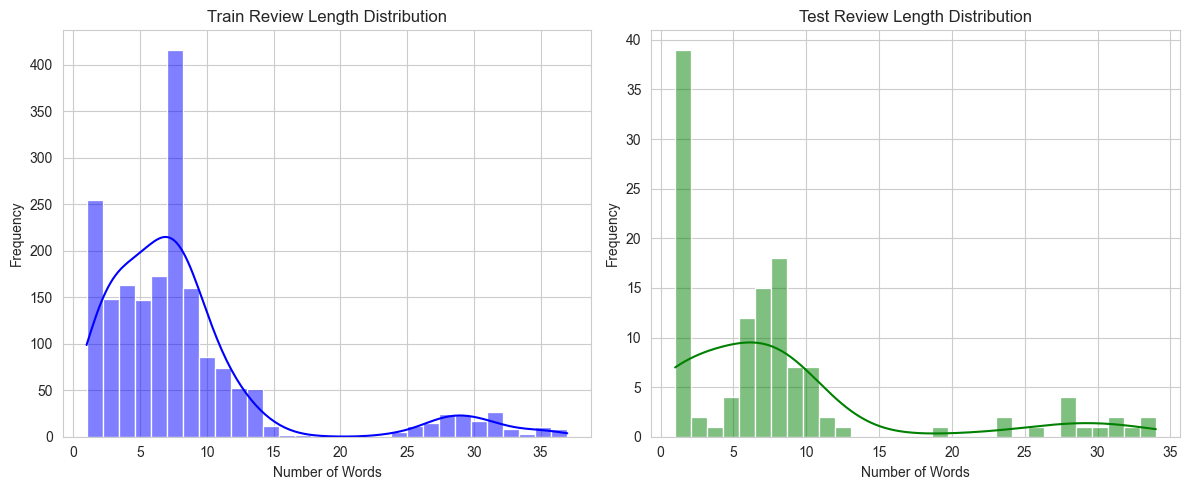

In [140]:
# analyze review lengths in the train and test datasets

# calculate the length of each review (number of words)
train_ds['Review_Length'] = train_ds['Review'].apply(lambda x: len(str(x).split()))
test_ds['Review_Length'] = test_ds['Review'].apply(lambda x: len(str(x).split()))

# display basic statistics
print("Train Review Length Statistics:")
print(train_ds['Review_Length'].describe())

print("\nTest Review Length Statistics:")
print(test_ds['Review_Length'].describe())

# plot histograms to visualize the distribution of review lengths
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_ds['Review_Length'], bins=30, kde=True, color='blue')
plt.title('Train Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_ds['Review_Length'], bins=30, kde=True, color='green')
plt.title('Test Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# show the plots
plt.tight_layout()
plt.show()

#

### **Visualizing Most Common Words**
###### - Identifying and visualizing the most frequent words in the reviews helps understand the main topics and themes in the dataset.
###### - This can provide insights into the data and guide further preprocessing or feature engineering.

C:\Users\ezinn\AppData\Local\Temp\ipykernel_150900\2479187227.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


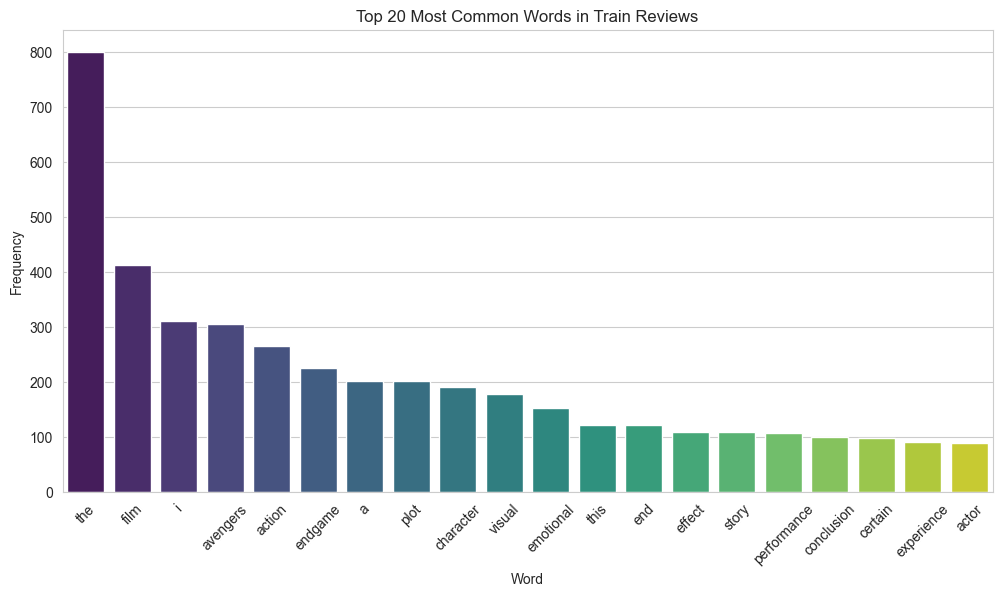

In [141]:
# visualize the most common words in the train dataset reviews

# combine all reviews into a single string and split into words
all_words = ' '.join(train_ds['Review']).split()

# count word frequencies
word_counts = Counter(all_words)

# get the 20 most common words
most_common_words = word_counts.most_common(20)

# separate words and counts for plotting
words, counts = zip(*most_common_words)

# plot the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('Top 20 Most Common Words in Train Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#

# **Base Model**
###### - This base model will be used. 
###### - It will be evaluated first, and then after improvements and hyperparameter tuning, the final model will be compared with this one to see if there is any improvements.

In [142]:
# prepare the data for training

max_words = 5000  # maximum vocabulary size (consider only the top 5000 words)
max_len = 100     # maximum number of words per review, reviews will be padded/truncated to this length

# initialize the tokenizer; 'oov_token' is used for words not in the vocabulary
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_ds['Review'])  # build the word index based on the training reviews

# convert text reviews into sequences of integers for both training and test sets
X_train = tokenizer.texts_to_sequences(train_ds['Review'])
X_test = tokenizer.texts_to_sequences(test_ds['Review'])

# pad sequences so every review has the same length (max_len)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# encode the labels:

# first, create a mapping from rating labels to numeric indices
label_map = {label: idx for idx, label in enumerate(train_ds['Rating'].unique())}
# map the rating labels in both training and test sets using the label map
y_train = train_ds['Rating'].map(label_map)
y_test = test_ds['Rating'].map(label_map)

# convert the numeric labels to one-hot encoded vectors for multiclass classification
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

In [143]:
# build the rnn model for text classification

# define the model architecture
model = Sequential([

    # embedding layer: converts integer sequences into dense vector representations
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),

    # simple rnn layer to capture sequential information from the text
    SimpleRNN(64, return_sequences=False),

    # dropout layer to reduce overfitting by randomly dropping some neurons during training
    Dropout(0.3),

    # dense layer for feature extraction with relu activation
    Dense(32, activation='relu'),

    # output layer with softmax activation for multiclass classification
    Dense(len(label_map), activation='softmax')

])

# compile the model using categorical crossentropy loss (suitable for multiclass classification)
# and the adam optimizer; also track accuracy during training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])


# set up callbacks and train the model

# early stopping to halt training when the validation loss does not improve after 3 epochs,
# and restore the best weights encountered during training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# reduce the learning rate if the validation loss plateaus for 2 epochs; the lr is reduced by a factor of 0.5
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# train the model using training data as a validation set
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # reserve 20% of training data for validation
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
48/48 [==============================] - 18s 306ms/step - loss: 1.4782 - accuracy: 0.3862 - recall: 0.0278 - precision: 0.4828 - val_loss: 0.8847 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 13s 263ms/step - loss: 1.4427 - accuracy: 0.4107 - recall: 0.0450 - precision: 0.4172 - val_loss: 0.9368 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 1.4363 - accuracy: 0.4200 - recall: 0.0608 - precision: 0.4488
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 [==============================] - 14s 283ms/step - loss: 1.4363 - accuracy: 0.4200 - recall: 0.0608 - precision: 0.4488 - val_loss: 0.9928 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 12s 259ms/

#

# **Evaluating the base model**
###### - Now we evaluate the base model to see how it performs. 
###### - This model is just a base, and will be used to compare with the final model to see if there were any improvements made given the efforts. 
###### - We will use a confusion matrix too to evaluate the model. 
###### - **Metrics used : Loss (categorical crossentropy)**, the usual loss for multi-class classification.
###### - **Metrics used : Accuracy**, a usual measure of how accurate model predicts classes. 
###### - **Metrics used : Precision**, useful to see how reliable predictions are for each class.
###### - **Metrics used : Recall**, helps understand how many examples of a class are being captured.


In [144]:
# evaluate the model on the test set

# evaluate and print the test loss and test accuracy
test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall : {test_recall:.4f}")
print(f"Test Precision : {test_precision:.4f}")

Test Loss: 1.2574
Test Accuracy: 0.5610
Test Recall : 0.4228
Test Precision : 0.7324


4/4 [==============================] - 0s 18ms/step


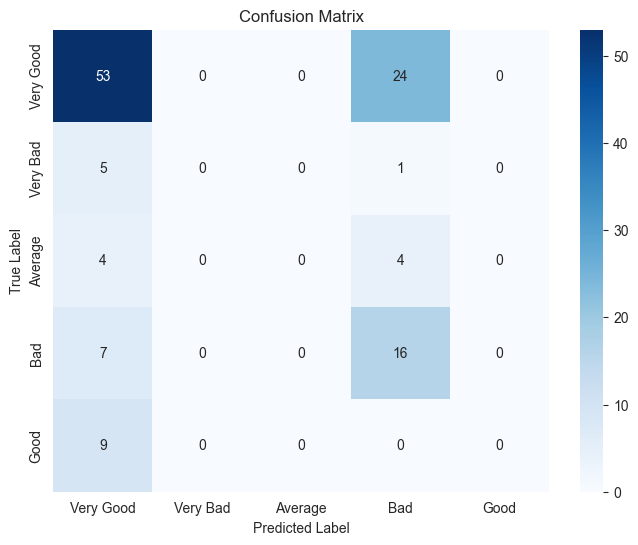

In [145]:
# plot the confusion matrix 

# get predictions from the model (probabilities)
y_pred_probs = model.predict(X_test)

# convert probabilities to predicted class labels (indices)
y_pred = np.argmax(y_pred_probs, axis=1)

# convert true labels from one-hot encoding back to class labels (indices)
y_true = np.argmax(y_test, axis=1)

# compute the confusion matrix
cm_base = confusion_matrix(y_true, y_pred)

# get the class labels for plotting

# ensure they are sorted to match the order in the confusion matrix
idx_to_label = {idx: label for label, idx in label_map.items()}
class_labels = [idx_to_label[i] for i in sorted(idx_to_label.keys())]

# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#

# **Model improvement**
###### - We can see that the base model has a serious issue. 
###### - Despite getting a good accuracy, the model is only good at predicting classes that are "Very Good".
###### - To fix this, we try using class weights, because we already tried augmenting data infront. 
###### - We also use this instead of augmenting more data as the data for other classes is very small, if we augment more, there'll be much more duplicates and much more artificial data, which may not be useful.
###### - Using class weights is a preferred solution as it ensures the model is penalized more for misclassifying minority classes, forcing it to learn their unique features.

In [146]:
# label encoding the 'Rating' column for class weights calculation

label_encoder = LabelEncoder()
ds['Rating'] = label_encoder.fit_transform(ds['Rating'])  # Change 'label' to your column name

# see the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# class weights calculation
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ds['Rating']),
    y=ds['Rating']
)

# convert to dictionary
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Label mapping: {'Average': 0, 'Bad': 1, 'Good': 2, 'Very Bad': 3, 'Very Good': 4}
Class weights: {0: 3.037037037037037, 1: 1.0512820512820513, 2: 2.7333333333333334, 3: 4.1, 4: 0.3215686274509804}


#

# **Re-evaluating model**
###### - Now that class weights is applied, let's try and evaluate the model again and see if anything changes.

In [147]:
# build the rnn model for text classification

# define the model architecture
model = Sequential([

    # embedding layer: converts integer sequences into dense vector representations
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),

    # simple rnn layer to capture sequential information from the text
    SimpleRNN(64, return_sequences=False),

    # dropout layer to reduce overfitting by randomly dropping some neurons during training
    Dropout(0.3),

    # dense layer for feature extraction with relu activation
    Dense(32, activation='relu'),

    # output layer with softmax activation for multiclass classification
    Dense(len(label_map), activation='softmax')

])

# compile the model using categorical crossentropy loss (suitable for multiclass classification)
# and the adam optimizer; also track accuracy during training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])


# set up callbacks and train the model

# early stopping to halt training when the validation loss does not improve after 3 epochs,
# and restore the best weights encountered during training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# reduce the learning rate if the validation loss plateaus for 2 epochs; the lr is reduced by a factor of 0.5
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# train the model using training data as a validation set
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # reserve 20% of training data for validation
    verbose=1,
    callbacks=[early_stop, reduce_lr], 
    class_weight=class_weight_dict  # use the computed class weights
)

# evaluate the model on the test set

# evaluate and print the test loss and test accuracy
test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")

Epoch 1/100
48/48 [==============================] - 7s 123ms/step - loss: 3.5442 - accuracy: 0.3360 - recall: 0.1290 - precision: 0.3854 - val_loss: 0.8641 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 5s 111ms/step - loss: 3.2099 - accuracy: 0.3743 - recall: 0.1601 - precision: 0.4088 - val_loss: 0.7859 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 5s 114ms/step - loss: 3.1996 - accuracy: 0.3717 - recall: 0.1488 - precision: 0.4278 - val_loss: 0.8312 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 3.2140 - accuracy: 0.4081 - recall: 0.1772 - precision: 0.4344
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 [==============================] - 6s 131ms/step

4/4 [==============================] - 0s 29ms/step


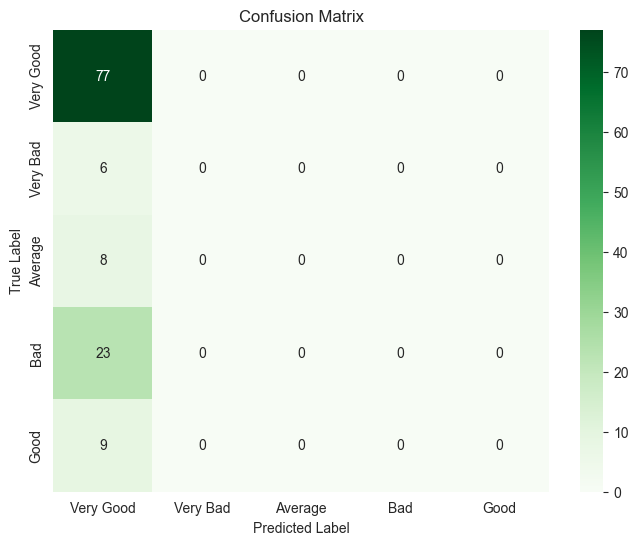

In [148]:
# plot the confusion matrix 

# get predictions from the model (probabilities)
y_pred_probs = model.predict(X_test)
# convert probabilities to predicted class labels (indices)
y_pred = np.argmax(y_pred_probs, axis=1)

# convert true labels from one-hot encoding back to class labels (indices)
y_true = np.argmax(y_test, axis=1)

# compute the confusion matrix
cm_class_weights = confusion_matrix(y_true, y_pred)

# get the class labels for plotting
# ensure they are sorted to match the order in the confusion matrix
idx_to_label = {idx: label for label, idx in label_map.items()}
class_labels = [idx_to_label[i] for i in sorted(idx_to_label.keys())]


# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_class_weights, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#

# **Hyperparameter tuning**
###### - Now we hyperparameter tune our base model. 
###### - We try to get the best parameters where the base model performs the best. 
###### - After that, we train a final model using these hyperparameters. 
###### - We include the class weights as an attempt to make the model better.


Training model 1 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 32}
Model 1 - Test Loss: 1.4843, Test Accuracy: 0.6341, Test Recall: 0.6260, Test Precision: 0.6525


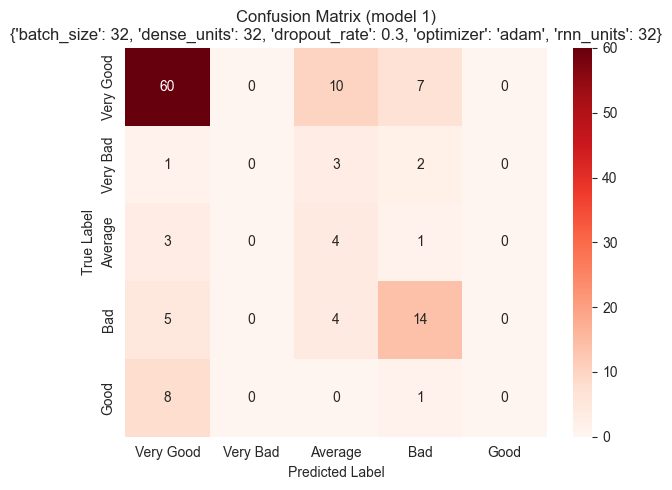


Training model 2 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 64}
Model 2 - Test Loss: 1.2504, Test Accuracy: 0.6260, Test Recall: 0.6260, Test Precision: 0.6260


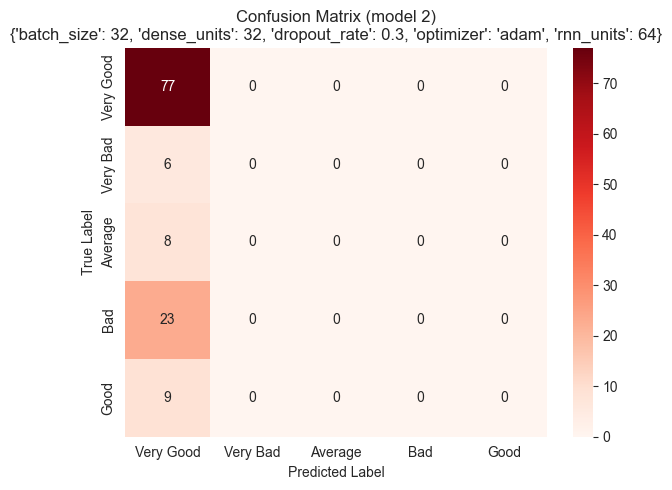


Training model 3 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 3 - Test Loss: 1.2480, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


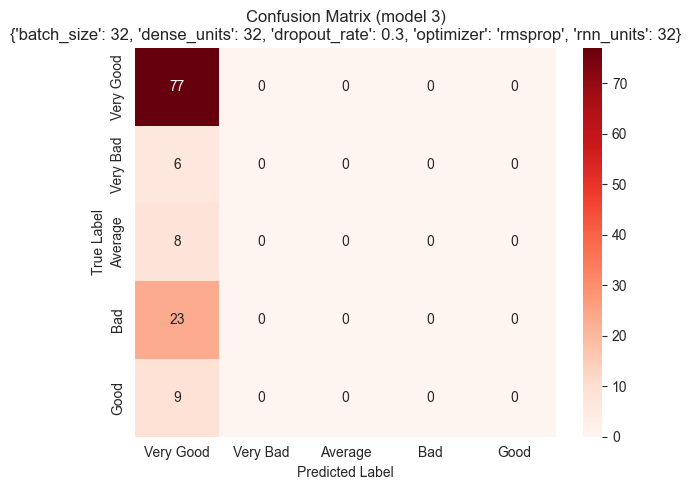


Training model 4 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 4 - Test Loss: 1.2400, Test Accuracy: 0.6179, Test Recall: 0.2602, Test Precision: 0.7111


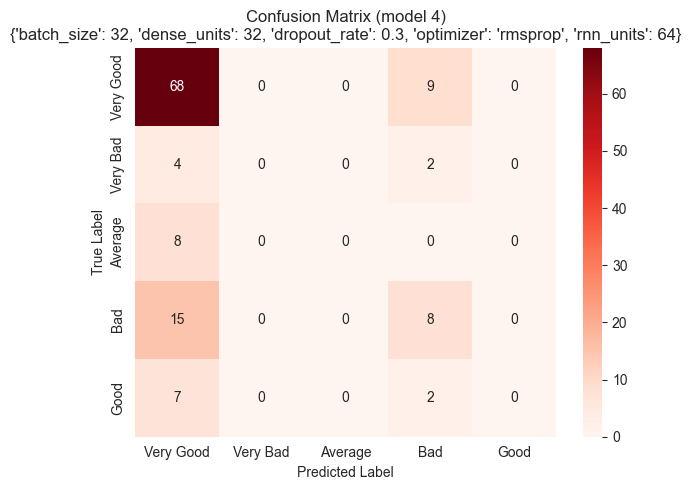


Training model 5 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 32}
Model 5 - Test Loss: 1.5426, Test Accuracy: 0.6260, Test Recall: 0.6260, Test Precision: 0.6471


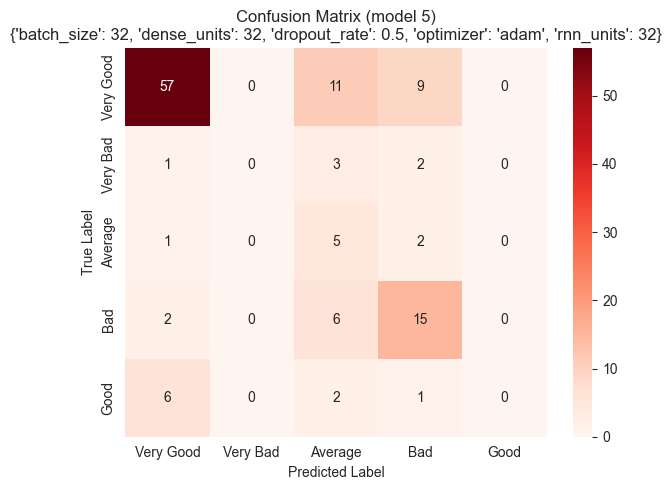


Training model 6 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 64}
Model 6 - Test Loss: 1.2801, Test Accuracy: 0.5528, Test Recall: 0.5285, Test Precision: 0.6500


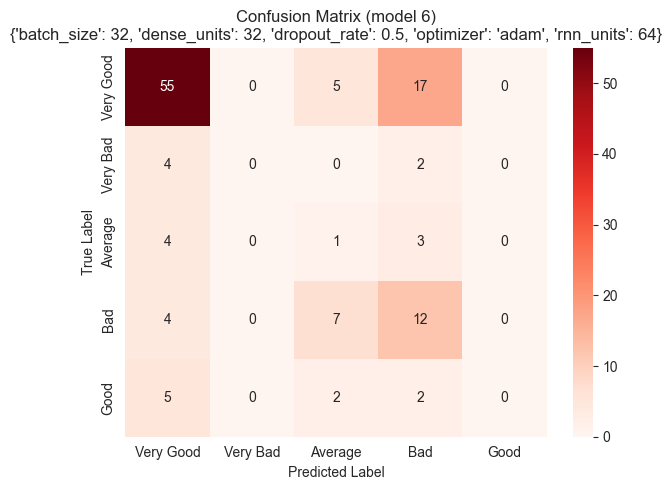


Training model 7 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 7 - Test Loss: 1.3811, Test Accuracy: 0.5285, Test Recall: 0.4878, Test Precision: 0.5714


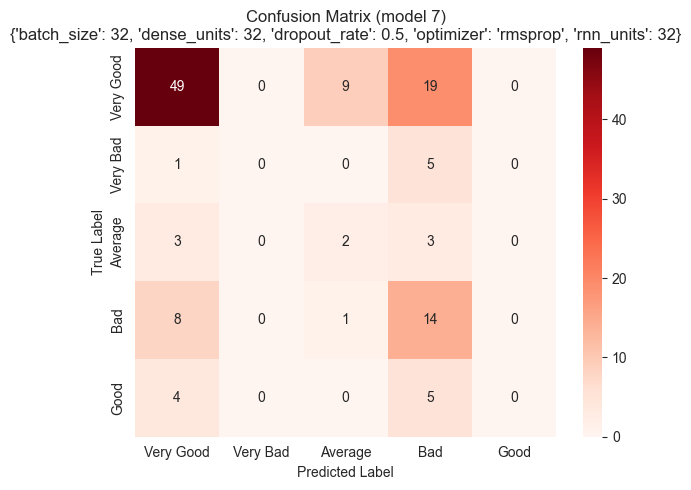


Training model 8 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 8 - Test Loss: 1.2745, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


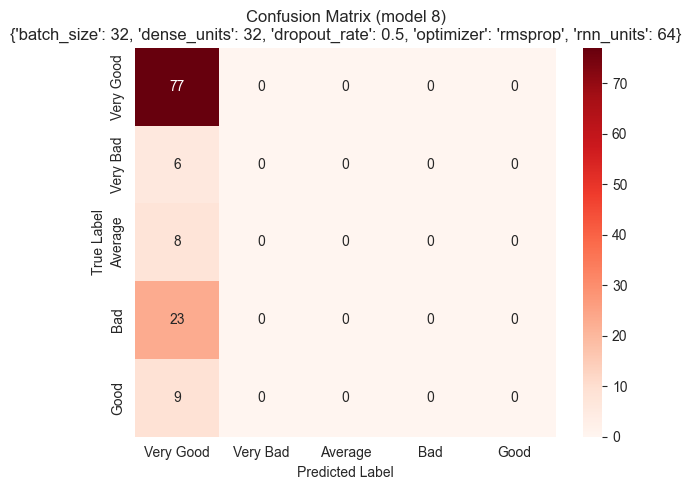


Training model 9 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 32}
Model 9 - Test Loss: 1.2327, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


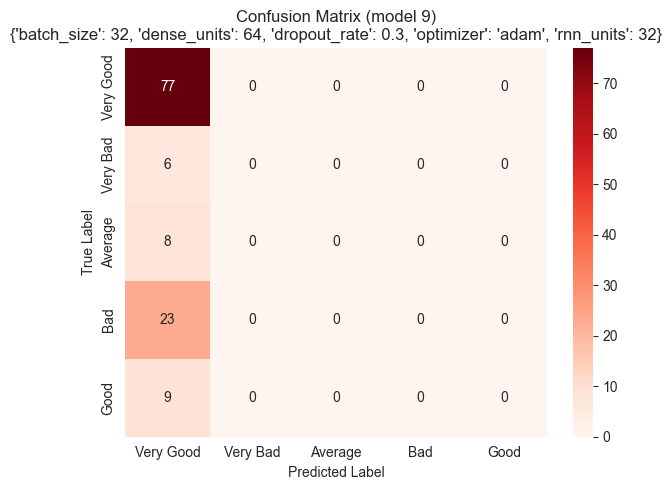


Training model 10 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 64}
Model 10 - Test Loss: 1.7821, Test Accuracy: 0.5935, Test Recall: 0.5854, Test Precision: 0.6316


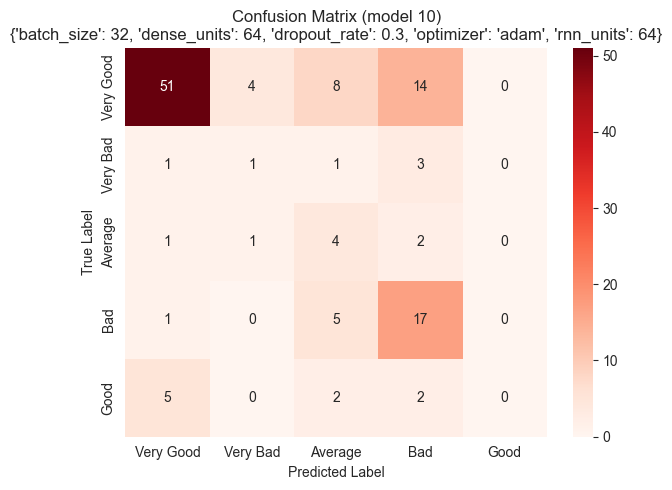


Training model 11 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 11 - Test Loss: 1.2541, Test Accuracy: 0.6260, Test Recall: 0.3577, Test Precision: 0.6197


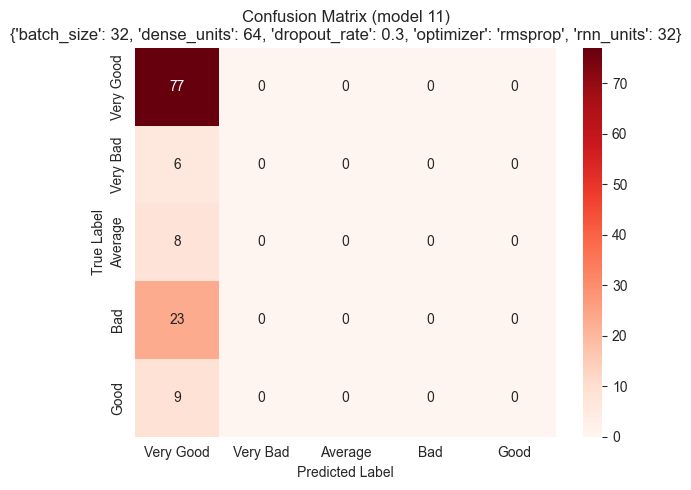


Training model 12 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 12 - Test Loss: 1.2916, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


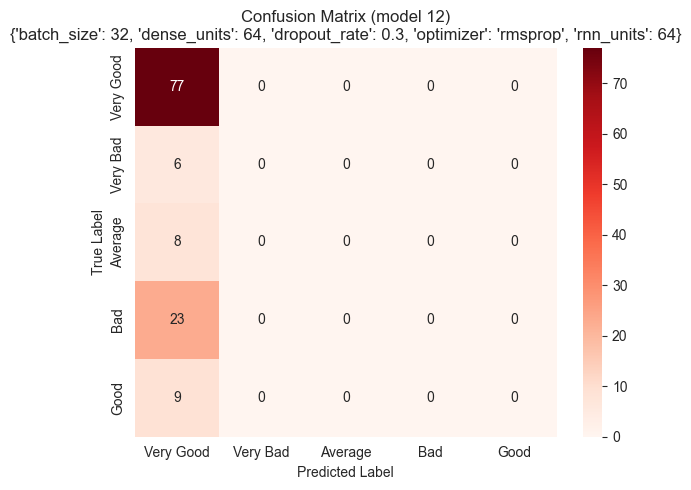


Training model 13 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 32}
Model 13 - Test Loss: 1.2340, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


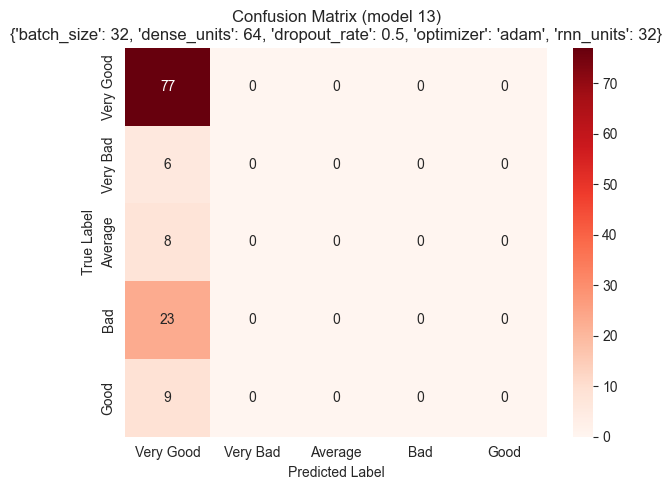


Training model 14 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 64}
Model 14 - Test Loss: 1.2544, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


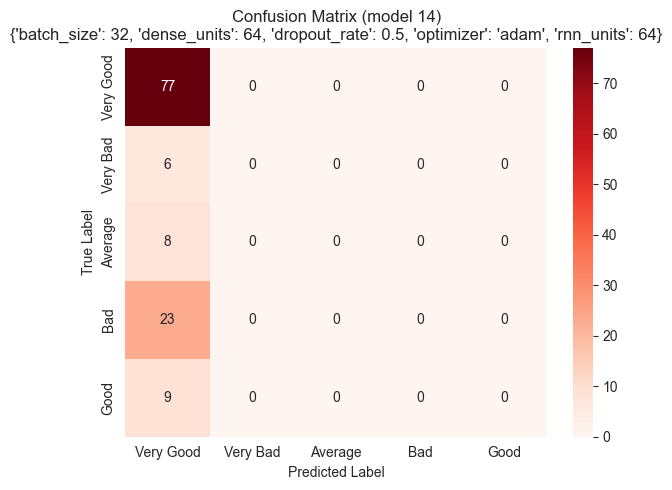


Training model 15 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 15 - Test Loss: 1.2739, Test Accuracy: 0.6260, Test Recall: 0.0000, Test Precision: 0.0000


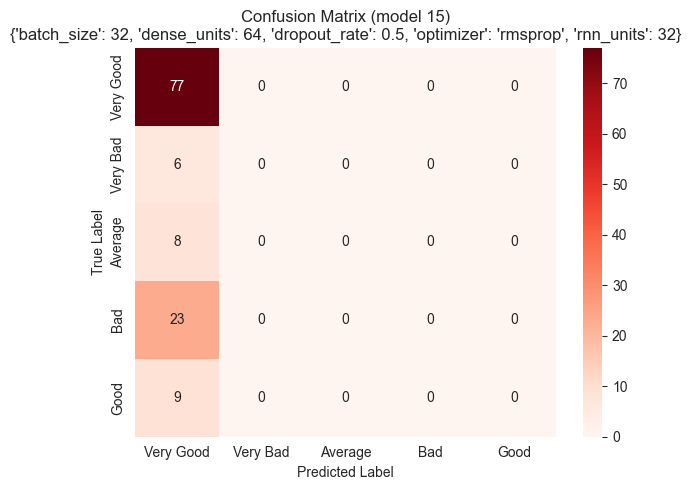


Training model 16 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 16 - Test Loss: 1.2402, Test Accuracy: 0.6260, Test Recall: 0.6260, Test Precision: 0.6260


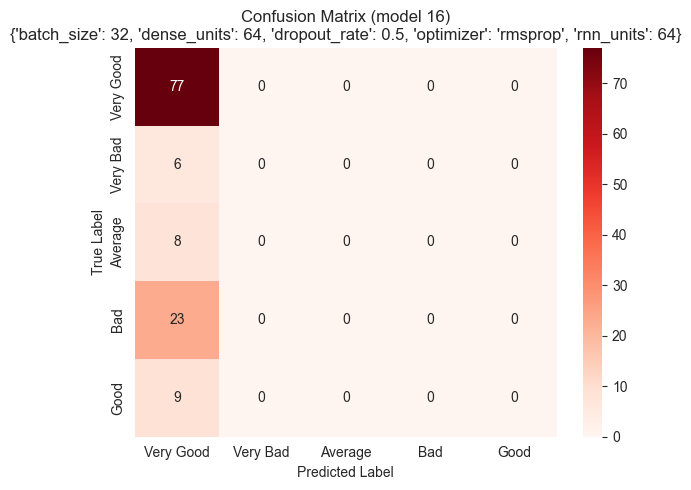

In [149]:
# parameter grid to tune
param_grid = {
    'rnn_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32]
}

# all results will be stored in this list 
results = []

# using ParameterGrid to iterate through all combinations of hyperparameters
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"\nTraining model {i + 1} with parameters: {params}")

    # Build model
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
        SimpleRNN(params['rnn_units'], return_sequences=False),
        Dropout(params['dropout_rate']),
        Dense(params['dense_units'], activation='relu'),
        Dense(len(label_map), activation='softmax')
    ])

    # compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=params['optimizer'],
        metrics=['accuracy', 'Recall', 'Precision']
    )

    # early stopping and learning rate reduction callbacks 
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

    # train the model 
    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=params['batch_size'],
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stop, reduce_lr],
        class_weight=class_weight_dict
    )

    # evaluate the model on the test set
    y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # print the evaluation metrics
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model {i + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test Precision: {test_precision:.4f}")

    # store the results
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f"Confusion Matrix (model {i + 1})\n{params}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

#

# **Evaluating tuned model**
###### - Now we evaluate the model that has been tuned. 
###### - The model's best parameters will be the set that provides the best precision without blindly predicting one class.

- Best model is model 7 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 32}
- Model 7 achieved --> Test Loss: 1.2526, Test Accuracy: 0.5366, Test Recall: 0.4634, Test Precision: 0.6951

In [150]:
# build the rnn model for text classification using best hyperparameters 

# define the model architecture
model = Sequential([

    # embedding layer: converts integer sequences into dense vector representations
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),

    # simple rnn layer to capture sequential information from the text
    SimpleRNN(32, return_sequences=False),

    # dropout layer to reduce overfitting by randomly dropping some neurons during training
    Dropout(0.5),

    # dense layer for feature extraction with relu activation
    Dense(32, activation='relu'),

    # output layer with softmax activation for multiclass classification
    Dense(len(label_map), activation='softmax')

])

# compile the model using categorical crossentropy loss (suitable for multiclass classification)
# and the adam optimizer; also track accuracy during training
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Recall', 'Precision'])


# set up callbacks and train the model

# early stopping to halt training when the validation loss does not improve after 3 epochs,
# and restore the best weights encountered during training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# reduce the learning rate if the validation loss plateaus for 2 epochs; the lr is reduced by a factor of 0.5
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# train the model using training data as a validation set
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # reserve 20% of training data for validation
    verbose=1,
    callbacks=[early_stop, reduce_lr], 
    class_weight=class_weight_dict  # use the computed class weights
)

# evaluate the model on the test set

# evaluate and print the test loss and test accuracy
test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")

Epoch 1/100
48/48 [==============================] - 7s 119ms/step - loss: 3.7461 - accuracy: 0.3876 - recall: 0.0708 - precision: 0.3891 - val_loss: 0.7956 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 5s 100ms/step - loss: 3.2670 - accuracy: 0.3823 - recall: 0.1362 - precision: 0.3992 - val_loss: 0.8515 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 5s 101ms/step - loss: 3.2113 - accuracy: 0.3823 - recall: 0.1323 - precision: 0.4237 - val_loss: 0.7677 - val_accuracy: 0.8338 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 5s 97ms/step - loss: 3.2181 - accuracy: 0.4061 - recall: 0.1495 - precision: 0.4511 - val_loss: 1.0231 - val_accuracy: 0.1583 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 5/100
48/48

4/4 [==============================] - 1s 45ms/step


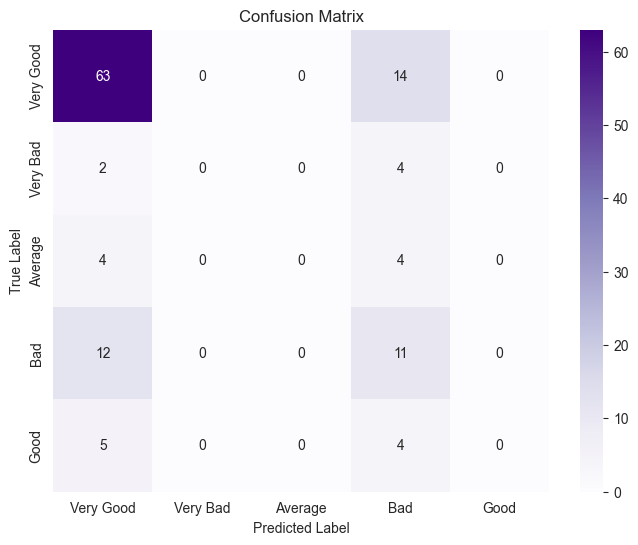

In [151]:
# plot the confusion matrix 

# get predictions from the model (probabilities)
y_pred_probs = model.predict(X_test)
# convert probabilities to predicted class labels (indices)
y_pred = np.argmax(y_pred_probs, axis=1)

# convert true labels from one-hot encoding back to class labels (indices)
y_true = np.argmax(y_test, axis=1)

# compute the confusion matrix
cm_class_weights_and_tune = confusion_matrix(y_true, y_pred)

# get the class labels for plotting
# ensure they are sorted to match the order in the confusion matrix
idx_to_label = {idx: label for label, idx in label_map.items()}
class_labels = [idx_to_label[i] for i in sorted(idx_to_label.keys())]


# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_class_weights_and_tune, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#

# **Model improvement**
###### - Here we improve the model. 
###### - We see that even while hyperparameter tuning, the model still predicts everything to be in "Very Good", for some of the hyperparameters. 
###### - We will try augmenting the data one more time to see if it helps.

In [152]:
# separate majority and minority classes
ds_majority = train_ds[train_ds['Rating'] == 'Very Good']
ds_minority = train_ds[train_ds['Rating'] != 'Very Good']  # all other classes

# downsample majority class to match smallest minority class
ds_majority_downsampled = resample(
    ds_majority,
    replace=False,  # no replacement for downsampling
    n_samples=ds_minority['Rating'].value_counts().max(),  
    random_state=42
)

# combine downsampled majority with all minority class samples
ds_train_balanced = pd.concat([ds_majority_downsampled, ds_minority])

# shuffle the balanced dataset
train_ds_improved = ds_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# print the new shape of the balanced training dataset
print(f"Balanced training dataset shape: {ds_train_balanced.shape}") 

Balanced training dataset shape: (1367, 3)


C:\Users\ezinn\AppData\Local\Temp\ipykernel_150900\1172410157.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='inferno')


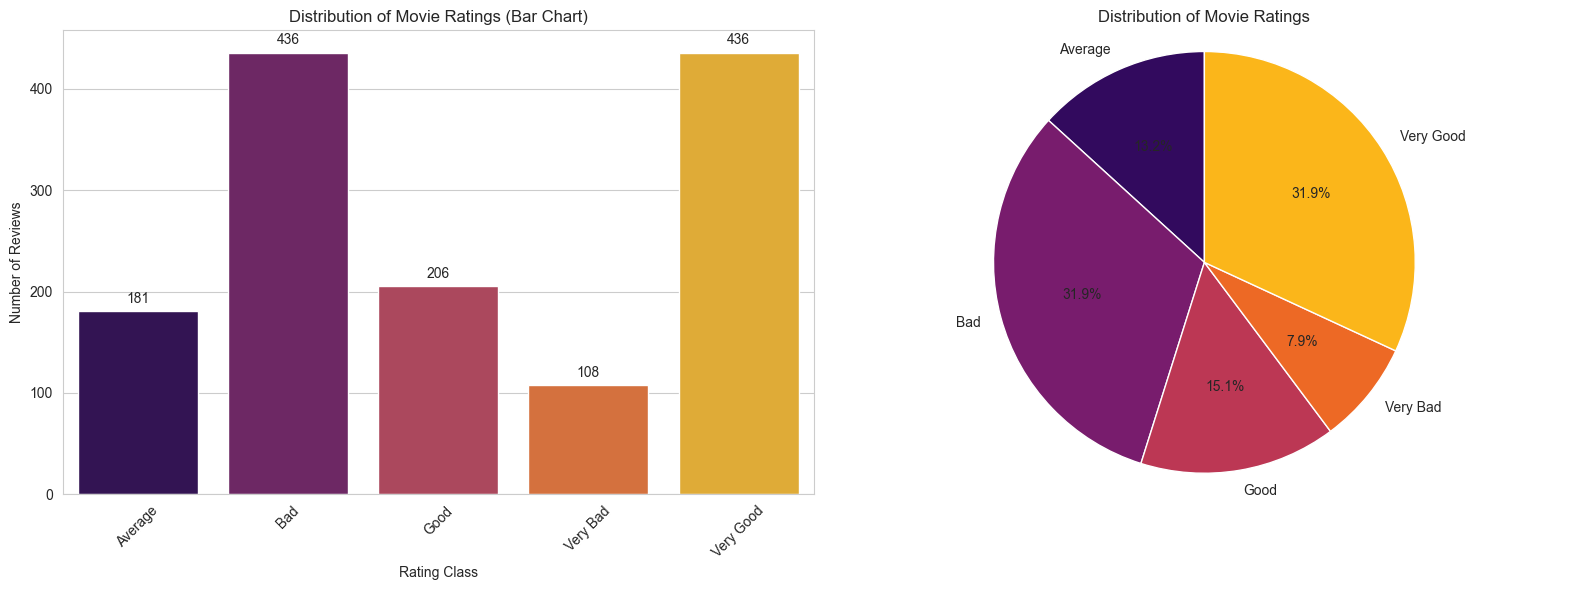

In [153]:
# now we visualize the distribution of the ratings using bar and pie charts
# this is after downsampling the majority class to balance the dataset
# this is an attempt to improve the model performance by addressing class imbalance in the train data

# set a style for the plots
sns.set_style("whitegrid")

# creating a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

####################################################################################################################################

# plotting the bar chart 
rating_counts = train_ds_improved['Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0], palette='inferno')
axes[0].set_title('Distribution of Movie Ratings (Bar Chart)')
axes[0].set_xlabel('Rating Class')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45) # rotate x-axis labels for better readability

# add text labels on top of the bars
for index, value in enumerate(rating_counts.values):
    axes[0].text(index, value + 5, str(value), ha='center', va='bottom')

####################################################################################################################################

# plotting the pie chart to visualize the distribution of movie ratings 

# calculate percentages for the pie chart
percentages = train_ds_improved['Rating'].value_counts(normalize=True).sort_index() * 100

# plotting the pie chart
axes[1].pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('inferno', len(percentages)))
axes[1].set_title('Distribution of Movie Ratings')
axes[1].axis('equal') # equal aspect ratio ensures that pie is drawn as a circle 

####################################################################################################################################

# show the plots
plt.tight_layout() 
plt.show()

### Since we are doing **downsampling**, we do not need to drop duplicates since no new data was added hence there is **no chance** of any duplicates appearing. Now we will try to tune again to see if the model gets better.

#

# **Re-tuning model one last time**
###### - Now that we tried to downsample the data for the "Very Good" class, we will tune the model again with train_ds_improved.
###### - This is an last attempt at fixing the model and hopefully it will turn out better.
###### - By logic, this should work because now the class that was overpowering everything was reduced to a smaller portion. 
###### - After doing so, we will take the hyper parameters that gave the best metrics (we mainly look at which model gives the best precision without predicting everything to be in the "Very Good" class).

In [154]:
# prepare the data for training again after balancing the dataset using downsampling

# we will use the same parameters as before with train_ds_improved

max_words = 5000  # maximum vocabulary size (consider only the top 5000 words)
max_len = 100     # maximum number of words per review, reviews will be padded/truncated to this length

# initialize the tokenizer; 'oov_token' is used for words not in the vocabulary
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_ds_improved['Review'])  # build the word index based on the training reviews

# convert text reviews into sequences of integers for both training and test sets
X_train = tokenizer.texts_to_sequences(train_ds_improved['Review'])
X_test = tokenizer.texts_to_sequences(test_ds['Review'])

# pad sequences so every review has the same length (max_len)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# encode the labels:

# first, create a mapping from rating labels to numeric indices
label_map = {label: idx for idx, label in enumerate(train_ds_improved['Rating'].unique())}
# map the rating labels in both training and test sets using the label map
y_train = train_ds_improved['Rating'].map(label_map)
y_test = test_ds['Rating'].map(label_map)

# convert the numeric labels to one-hot encoded vectors for multiclass classification
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))


Training model 1 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 32}
Model 1 - Test Loss: 1.4535, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


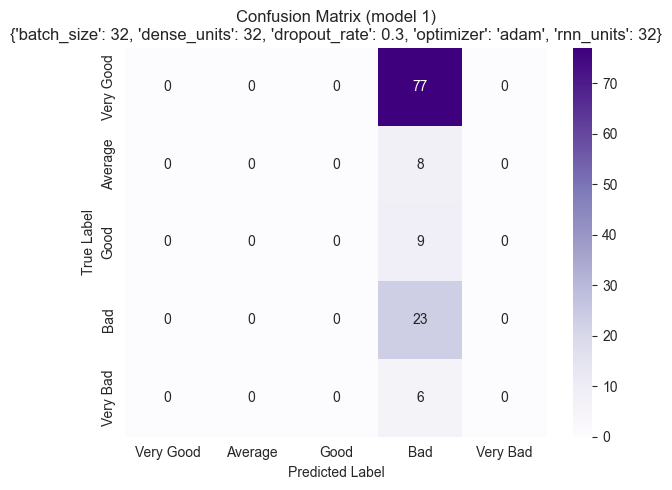


Training model 2 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 64}
Model 2 - Test Loss: 1.4435, Test Accuracy: 0.5041, Test Recall: 0.3171, Test Precision: 0.5000


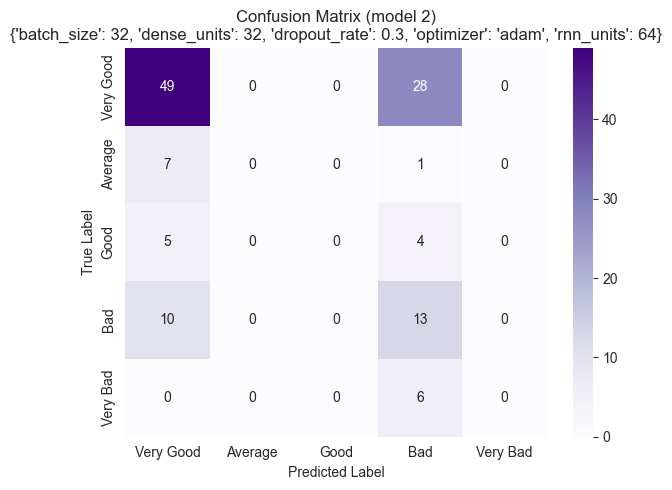


Training model 3 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 3 - Test Loss: 1.3696, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


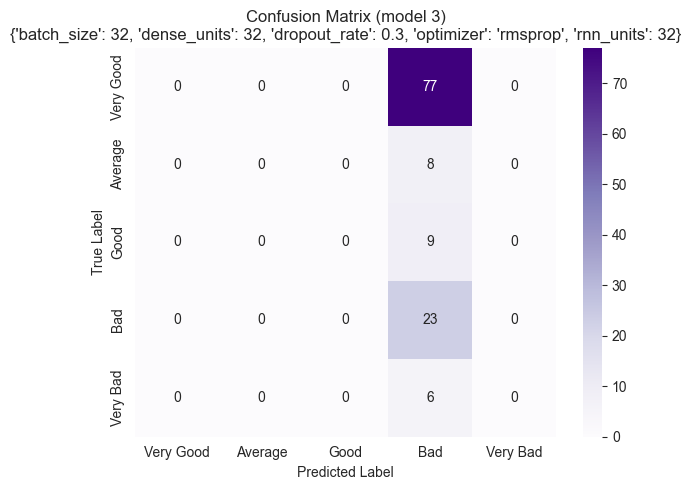


Training model 4 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 4 - Test Loss: 1.2889, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


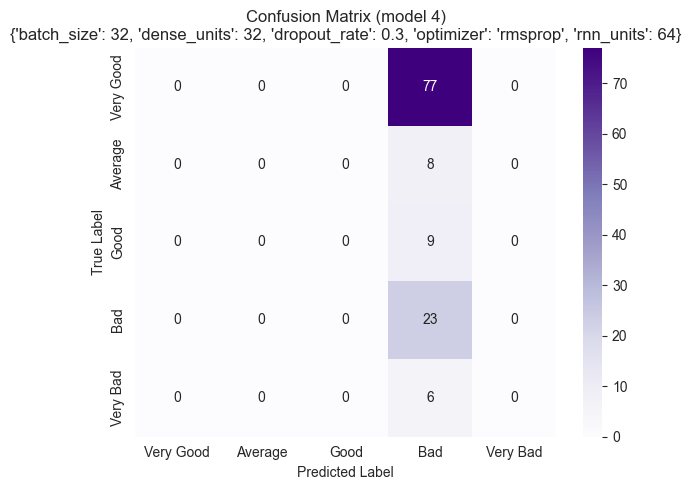


Training model 5 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 32}
Model 5 - Test Loss: 1.3561, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


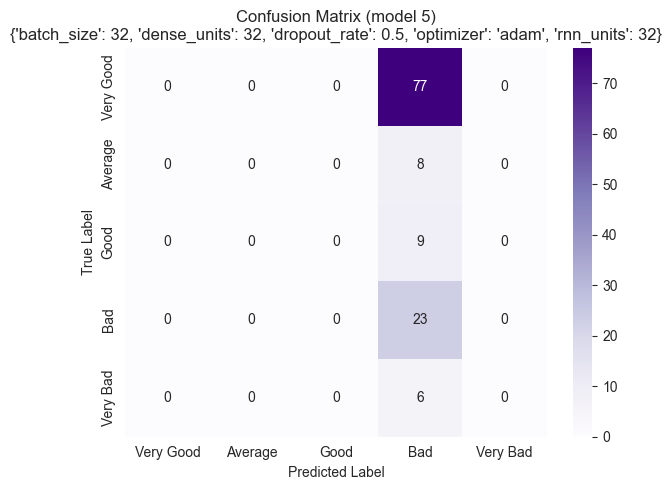


Training model 6 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 64}
Model 6 - Test Loss: 1.3571, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


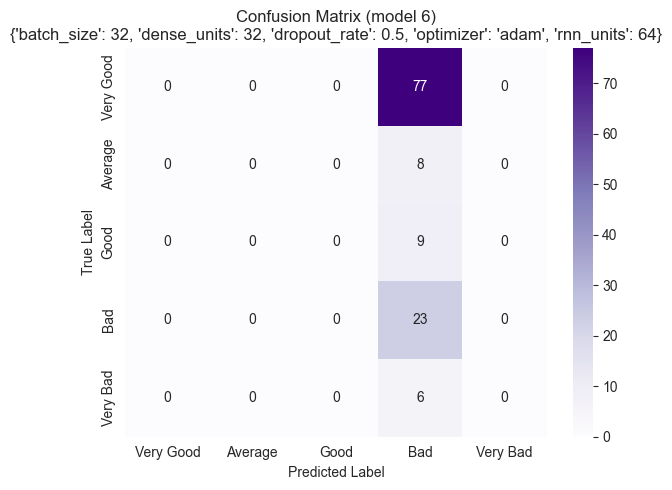


Training model 7 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 7 - Test Loss: 1.4441, Test Accuracy: 0.5528, Test Recall: 0.4959, Test Precision: 0.5701


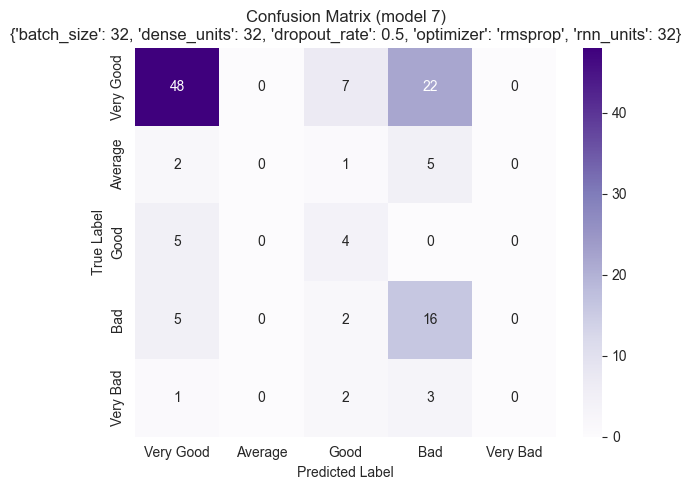


Training model 8 with parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 8 - Test Loss: 1.3391, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


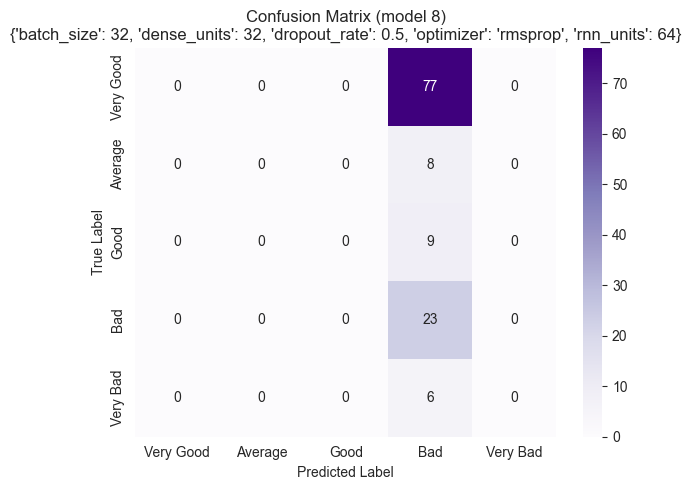


Training model 9 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 32}
Model 9 - Test Loss: 1.8938, Test Accuracy: 0.5285, Test Recall: 0.5122, Test Precision: 0.5250


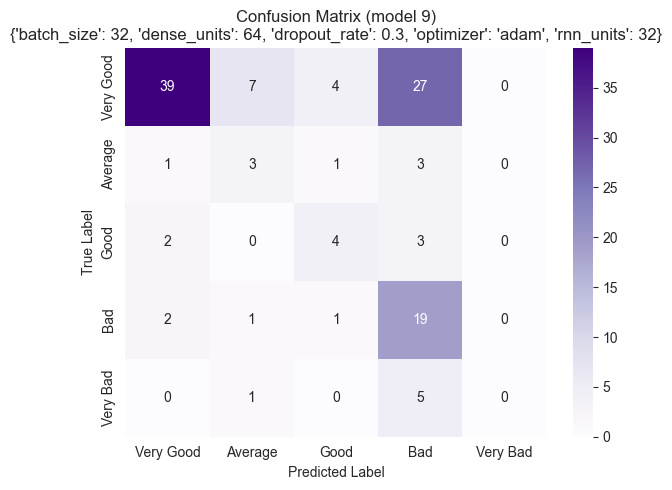


Training model 10 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'adam', 'rnn_units': 64}
Model 10 - Test Loss: 1.4054, Test Accuracy: 0.1951, Test Recall: 0.1220, Test Precision: 0.2083


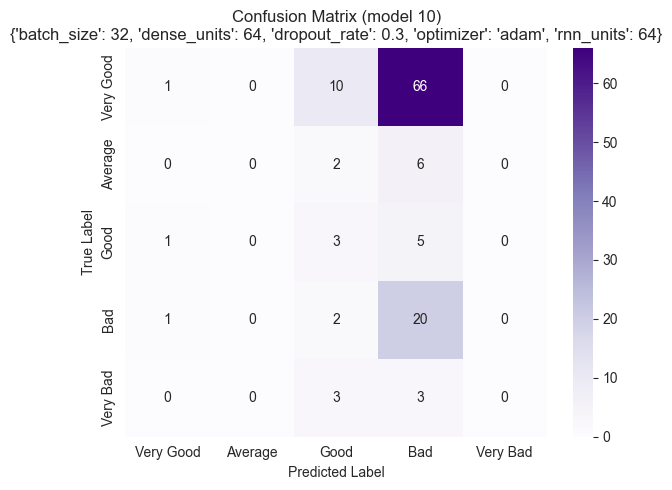


Training model 11 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 11 - Test Loss: 1.3407, Test Accuracy: 0.4472, Test Recall: 0.2602, Test Precision: 0.4571


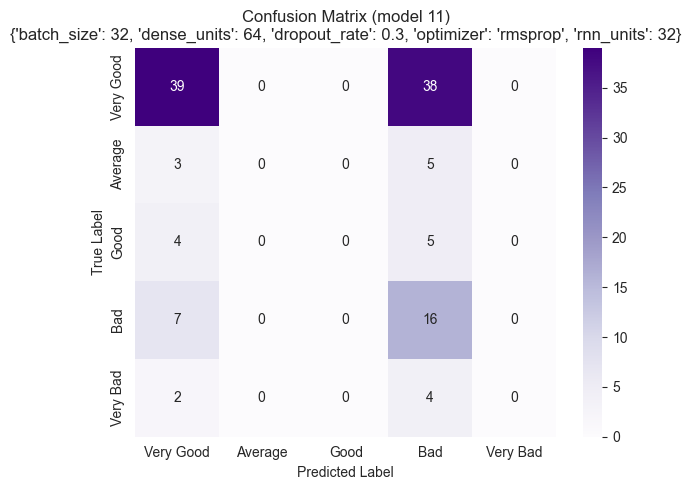


Training model 12 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 12 - Test Loss: 1.2912, Test Accuracy: 0.1870, Test Recall: 0.0081, Test Precision: 0.3333


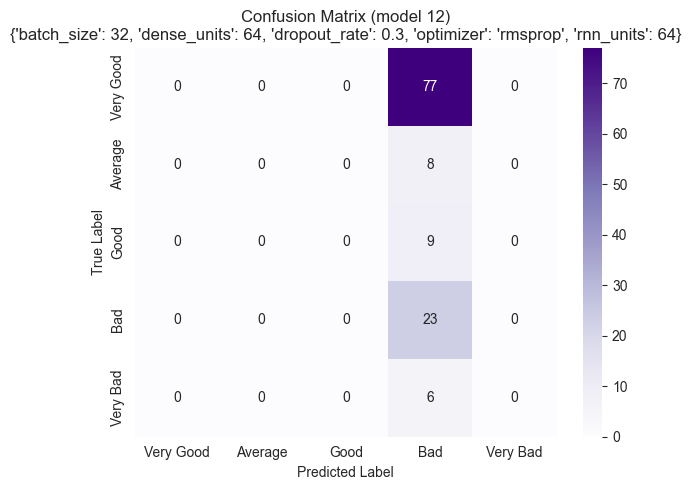


Training model 13 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 32}
Model 13 - Test Loss: 1.3361, Test Accuracy: 0.6504, Test Recall: 0.6423, Test Precision: 0.6529


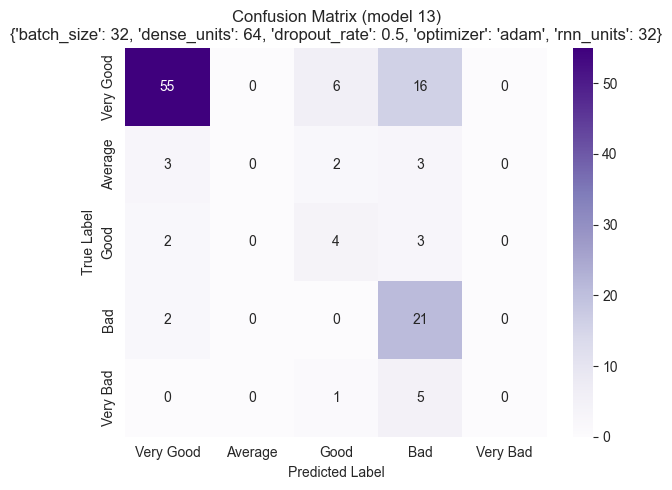


Training model 14 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 64}
Model 14 - Test Loss: 1.3319, Test Accuracy: 0.1870, Test Recall: 0.0000, Test Precision: 0.0000


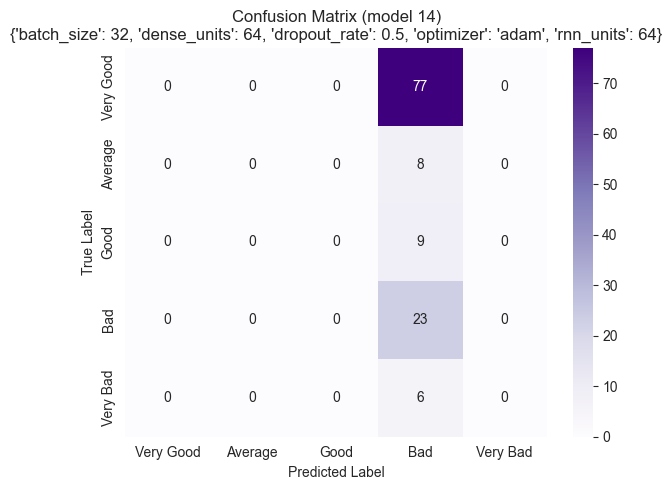


Training model 15 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 32}
Model 15 - Test Loss: 1.6660, Test Accuracy: 0.5447, Test Recall: 0.5447, Test Precision: 0.5537


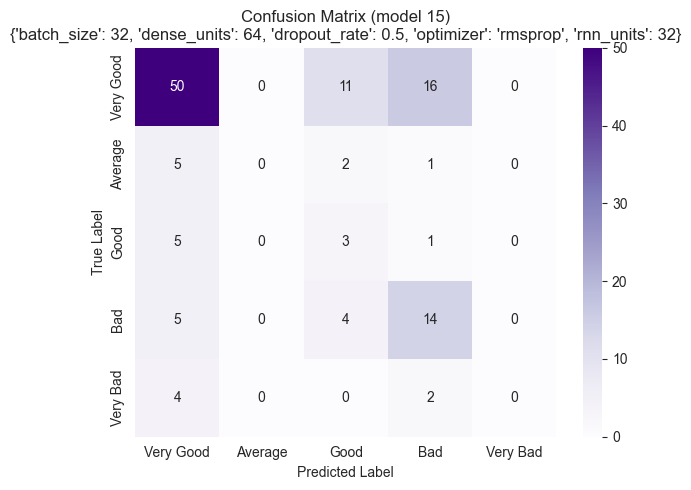


Training model 16 with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'rmsprop', 'rnn_units': 64}
Model 16 - Test Loss: 1.3499, Test Accuracy: 0.3008, Test Recall: 0.0000, Test Precision: 0.0000


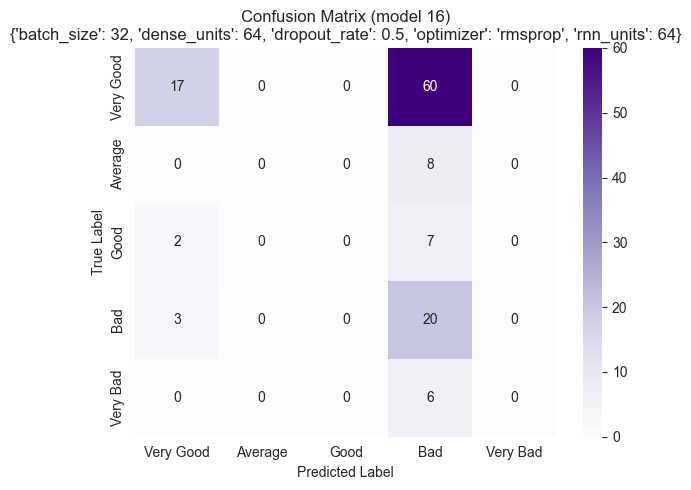

In [155]:
# retuning to the model training, we will now use the balanced dataset (train_ds_improved) for training
# we will alsp use the same preprocessing steps as before
# class weights will still be used to handle any remaining class imbalance

# parameter grid to tune
param_grid = {
    'rnn_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32]
}

# all results will be stored in this list 
results = []

# using ParameterGrid to iterate through all combinations of hyperparameters
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"\nTraining model {i + 1} with parameters: {params}")

    # Build model
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
        SimpleRNN(params['rnn_units'], return_sequences=False),
        Dropout(params['dropout_rate']),
        Dense(params['dense_units'], activation='relu'),
        Dense(len(label_map), activation='softmax')
    ])

    # compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=params['optimizer'],
        metrics=['accuracy', 'Recall', 'Precision']
    )

    # early stopping and learning rate reduction callbacks 
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

    # train the model 
    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=params['batch_size'],
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stop, reduce_lr],
        class_weight=class_weight_dict # included class weights to handle any remaining class imbalance
    )

    # evaluate the model on the test set
    y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # print the evaluation metrics
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model {i + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Recall: {test_recall:.4f}, Test Precision: {test_precision:.4f}")

    # store the results
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f"Confusion Matrix (model {i + 1})\n{params}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

#

# **Evaluating final model**
###### - Now that we have tried to hyperparameter tune and improve the model, we will evaluate it one last time. 
###### - This is to see if these methods of improving applied has any impact on the model. 
###### - This will be used to compare with the base model.

- Model 13 trained with parameters: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'rnn_units': 32}
- Model 13 achieved --> Test Loss: 1.5557, Test Accuracy: 0.5854, Test Recall: 0.5447, Test Precision: 0.5929

In [156]:
# build the rnn model for text classification using best hyperparameters 

# define the model architecture
model = Sequential([

    # embedding layer: converts integer sequences into dense vector representations
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),

    # simple rnn layer to capture sequential information from the text
    SimpleRNN(32, return_sequences=False),

    # dropout layer to reduce overfitting by randomly dropping some neurons during training
    Dropout(0.5),

    # dense layer for feature extraction with relu activation
    Dense(64, activation='relu'),

    # output layer with softmax activation for multiclass classification
    Dense(len(label_map), activation='softmax')

])

# compile the model using categorical crossentropy loss (suitable for multiclass classification)
# and the adam optimizer; also track accuracy during training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])


# set up callbacks and train the model

# early stopping to halt training when the validation loss does not improve after 3 epochs,
# and restore the best weights encountered during training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# reduce the learning rate if the validation loss plateaus for 2 epochs; the lr is reduced by a factor of 0.5
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# train the model using training data as a validation set
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # reserve 20% of training data for validation
    verbose=1,
    callbacks=[early_stop, reduce_lr], 
    class_weight=class_weight_dict  # use the computed class weights
)

# evaluate the model on the test set

# evaluate and print the test loss and test accuracy
test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")

Epoch 1/100
35/35 [==============================] - 5s 119ms/step - loss: 3.9822 - accuracy: 0.2845 - recall: 0.0457 - precision: 0.2874 - val_loss: 1.6486 - val_accuracy: 0.3467 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 4s 114ms/step - loss: 3.5274 - accuracy: 0.3321 - recall: 0.0723 - precision: 0.3027 - val_loss: 1.6028 - val_accuracy: 0.3467 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - 4s 110ms/step - loss: 3.4962 - accuracy: 0.3120 - recall: 0.0659 - precision: 0.3412 - val_loss: 1.6612 - val_accuracy: 0.3467 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 3.4967 - accuracy: 0.3092 - recall: 0.0897 - precision: 0.3006
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 [==============================] - 4s 107ms/step

4/4 [==============================] - 0s 14ms/step


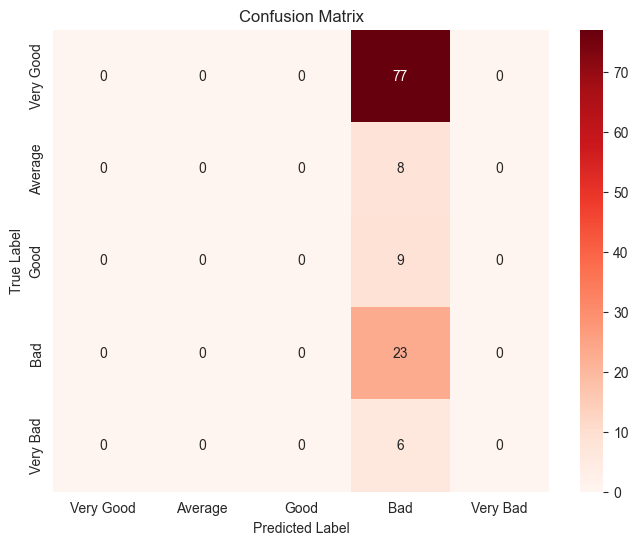

In [157]:
# plot the confusion matrix 

# get predictions from the model (probabilities)
y_pred_probs = model.predict(X_test)
# convert probabilities to predicted class labels (indices)
y_pred = np.argmax(y_pred_probs, axis=1)

# convert true labels from one-hot encoding back to class labels (indices)
y_true = np.argmax(y_test, axis=1)

# compute the confusion matrix
cm_final = confusion_matrix(y_true, y_pred)

# get the class labels for plotting
# ensure they are sorted to match the order in the confusion matrix
idx_to_label = {idx: label for label, idx in label_map.items()}
class_labels = [idx_to_label[i] for i in sorted(idx_to_label.keys())]


# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#

### **Saving final model weights**
###### - Since this is the last attempt at improving the model, this will be considered as the final model. 
###### - We will save the weights of the model into a .h5 file.

In [162]:
# saving the final model to a file for future use
model.save("simplernn_model.h5")

#

# **Comparing the models**
###### - Were there any differences in performance? 
###### - How big was the impact of improvisation?
###### - Why did these efforts to improve the model work or why they didnt work? 
###### - Which model performed better? The base or the final model?

Base Model Evaluation Metrics:


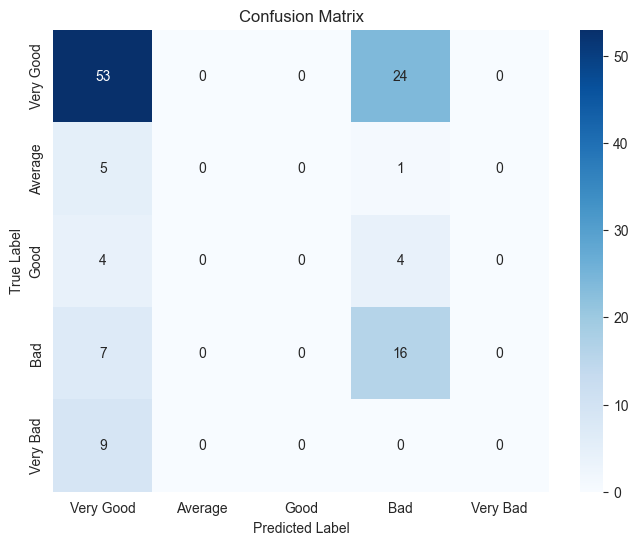

In [158]:
#########################################################################
# base model
#########################################################################
print("Base Model Evaluation Metrics:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Model With Class Weights Evaluation Metrics:


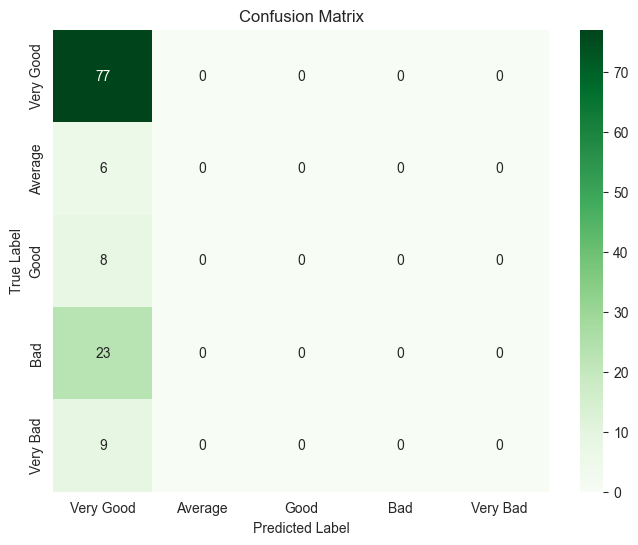

In [159]:
#########################################################################
# model after class weightage 
#########################################################################
print("Model With Class Weights Evaluation Metrics:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_class_weights, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Model With Class Weights And Tuning's Evaluation Metrics:


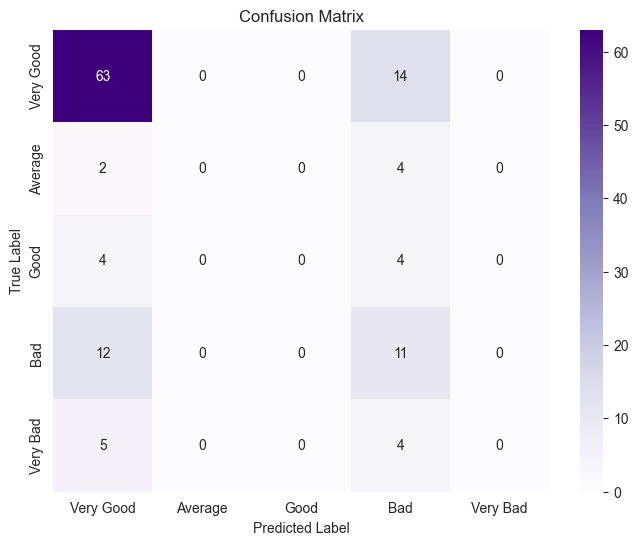

In [160]:
#########################################################################
# model after class weightage and tuning
#########################################################################
print("Model With Class Weights And Tuning's Evaluation Metrics:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_class_weights_and_tune, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Final Model Evaluation Metrics:


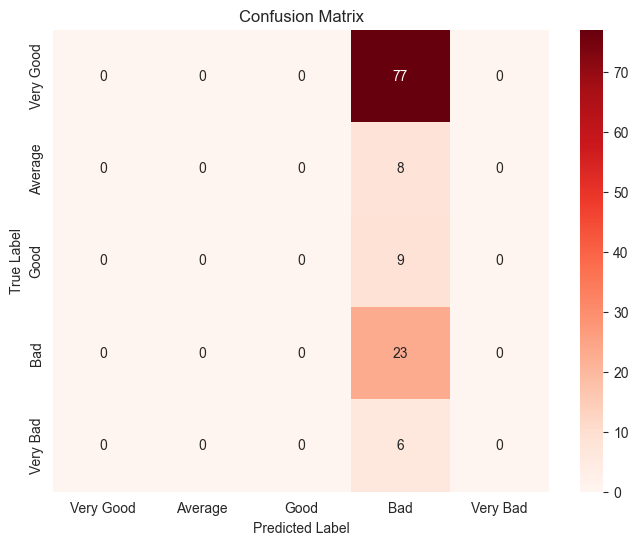

In [161]:
#########################################################################
# final model after 
#########################################################################
print("Final Model Evaluation Metrics:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#

# **Conclusion**
###### - Here's the conclusion and insights I have come up with after this project. 

### **All attempts to improve the model have been a failure despite trying almost everything**

- Since the efforts to improve the model once and once again were proved to have no effect / no improvement, the model most likely isn’t to blame for the outcome. 
- his was likely due to the dataset having too little data, and when we augment data, there’s only so much we can do. The data started out with 500 rows in total and was augmented upwards to about 1.9k, almost a 4x difference in terms of data, and the data created artificially through augmenting means might’ve been data that was contradicting, provided wrong info and insights to the model, or had anomalies. 
- Furthermore, to begin with, the data was too biased, by too big of a margin, that’s why before undersampling, all models tend to predict better on “Very Good”, as the amount of “Very Good” data was too much, both in the train and test, which still provided a decent accuracy. 
- It is important that the dataset used for training RNN models be prepared correctly, non-biased and sufficient for the model to be trained properly. 
- In this case, the data was not, that’s why efforts to improve both the model and the data all failed.
- Also, as visualized earlier, much of the data contained very little words and words with no meaning appeared a lot, like “the” being the most commonly used word, which showed that the dataset did’nt contain much information, which may have been another reason for these improvisation efforts to be a failure.


#

### **THE END**